# 0.0 Functions and Imports

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
import dtype_diet
from IPython.display import display, HTML
from IPython.display import Image
import seaborn as sns
import sweetviz as sv
from scipy.stats import chi2_contingency
from dython import nominal
from tabulate import tabulate
from scikitplot import metrics as mt
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder,OneHotEncoder, OrdinalEncoder,FunctionTransformer
from category_encoders import TargetEncoder
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel,RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn import model_selection, metrics
from xgboost import XGBClassifier
import lightgbm as lgbm
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [30, 20]
    plt.rcParams['font.size'] = 19
    display( HTML( '') )
    pd.set_option( 'display.expand_frame_repr', False )
    pd.options.display.max_columns = None
    sns.set(font_scale=1.5)
jupyter_settings()


def data_description(df):
    print('Variables:\n\n{}'.format(df.dtypes), end='\n\n')
    print('Number of rows {}'.format(df.shape[0]), end='\n\n')
    print('Number of columns {}'.format(df.shape[1]), end='\n\n')
    print('NA analysis'.format(end='\n') )
    for i in df.columns:
        print('column {}: {} {}'.format(i,df[i].isna().any(), df[i].isna().sum() ) )
        

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi), feature_names_out='one-to-one')


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi), feature_names_out='one-to-one')


from sklearn.base import BaseEstimator
class ClfSwitcher(BaseEstimator):

    def __init__(
        self, 
        estimator = RandomForestClassifier(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

# 1.0 Loading data

In [2]:
df_users = pd.read_csv('../data/raw/train_users_2.csv', low_memory=True)
df_otimized = dtype_diet.report_on_dataframe(df_users)
df_users = dtype_diet.optimize_dtypes(df_users, df_otimized)

del(df_otimized)

In [11]:
df_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.00,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.00,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.00,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.00,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


# 2.0 Data Description and Data Wrangling

In [3]:
df1 = df_users.copy()

In [38]:
data_description(df_users)

Variables:

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

Number of rows 213451

Number of columns 16

NA analysis
column id: False 0
column date_account_created: False 0
column timestamp_first_active: False 0
column date_first_booking: True 124543
column gender: False 0
column age: True 87990
column signup_method: False 0
column signup_flow: False 0
column language: False 0
column affiliate_channel: False 0
column affiliate_provider: False 0
column first_affiliate_t

## 2.1 Change Data Type

In [4]:
# timestamp_first_active
df1['timestamp_first_active'] =pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S').dt.strftime('%Y-%m-%d').astype('datetime64[ns]')

#date_account_created
df1['date_account_created']= df1['date_account_created'].astype('datetime64[ns]')
                                           
#date_first_booking
df1['date_first_booking']= df1['date_first_booking'].astype('datetime64[ns]')

#signup_flow
df1['signup_flow']= df1['signup_flow'].astype(int)


## 2.2 Check unique values

In [87]:
aux1 = df1.select_dtypes('category')
for i in aux1.columns:
    print('column {}: {}'.format(i,aux1[i].unique().tolist() ), end='\n\n' )

column gender: ['-unknown-', 'MALE', 'FEMALE', 'OTHER']

column signup_method: ['facebook', 'basic', 'google']

column signup_flow: [0, 3, 2, 1, 24, 8, 6, 5, 10, 25, 12, 4, 16, 15, 20, 21, 23]

column language: ['en', 'fr', 'de', 'es', 'it', 'pt', 'zh', 'ko', 'ja', 'ru', 'pl', 'el', 'sv', 'nl', 'hu', 'da', 'id', 'fi', 'no', 'tr', 'th', 'cs', 'hr', 'ca', 'is']

column affiliate_channel: ['direct', 'seo', 'other', 'sem-non-brand', 'content', 'sem-brand', 'remarketing', 'api']

column affiliate_provider: ['direct', 'google', 'other', 'craigslist', 'facebook', 'vast', 'bing', 'meetup', 'facebook-open-graph', 'email-marketing', 'yahoo', 'padmapper', 'gsp', 'wayn', 'naver', 'baidu', 'yandex', 'daum']

column first_affiliate_tracked: ['untracked', 'omg', nan, 'linked', 'tracked-other', 'product', 'marketing', 'local ops']

column signup_app: ['Web', 'Moweb', 'iOS', 'Android']

column first_device_type: ['Mac Desktop', 'Windows Desktop', 'iPhone', 'Other/Unknown', 'Desktop (Other)', 'Android T

In [196]:
#Check unique values for age
df1[pd.notnull(df1['age'] ) ]['age'].astype(int).unique()

array([  38,   56,   42,   41,   46,   47,   50,   36,   37,   33,   31,
         29,   30,   40,   26,   32,   35,   59,   49,   44,   34,   28,
         19,   53,   52,   39,   57,   25,   54,   69,   63,   43,   55,
         65,   58,   61,   18,    5,   27,   45,   60,   48,   51,   64,
         72,   70,   67,   73, 2014,  104,   66,  105,   68,   95,   24,
         94,   75,   79,   62, 2013,   16,    4,   23,  101,   98,   76,
         74,   87,   92,  115,   71,   84,  107,   78,   99,  110,  102,
         82,   77,   22,   89,   21,   15,   20,  103,    2,   17,   86,
         97,   81,   90,   88,   80,  100,   91,  106,   83,   85,  108,
        113,  109,   93,   96, 1949,  111, 1931, 1932,  112, 1928,    1,
       1936, 1933, 1935, 1925, 1952,  150, 1927,  132, 1953, 1942, 1995,
       2008, 1924, 1929, 1947, 1938, 1926])

<AxesSubplot: xlabel='age', ylabel='Count'>

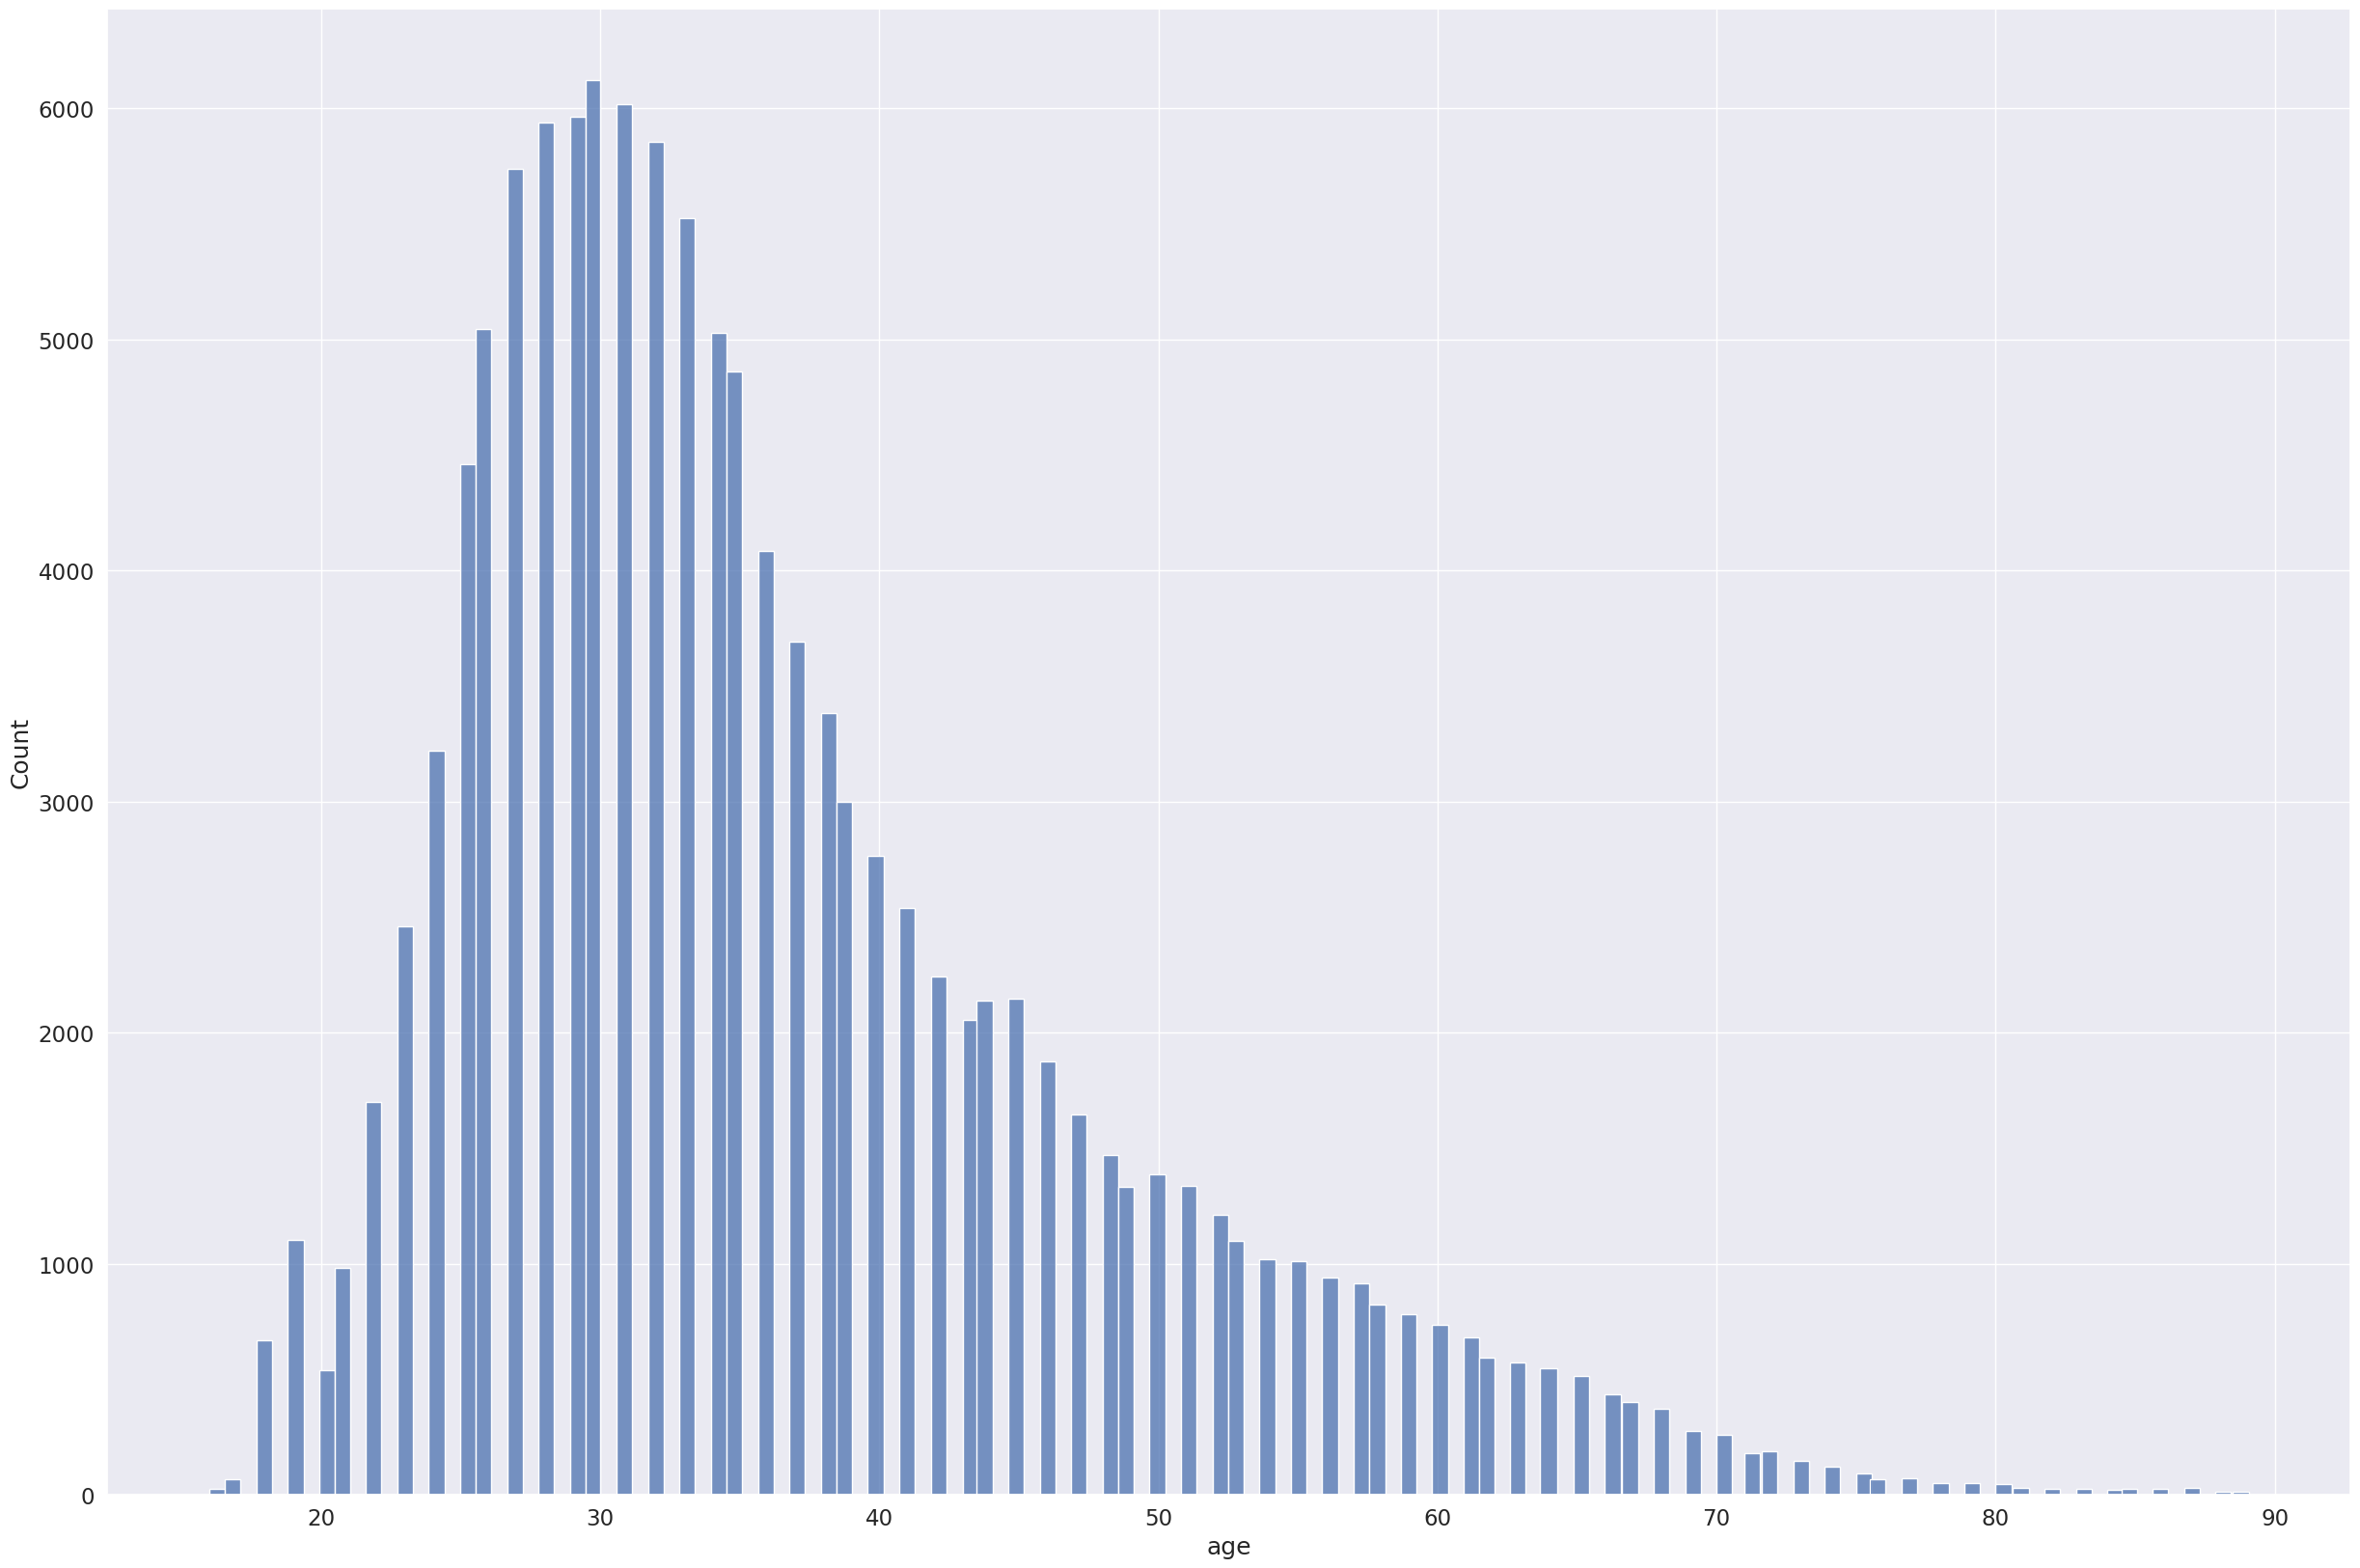

In [199]:
#checking distribution of age without NAs and filtering ages less than 90 and greater than 15
sns.histplot(x='age', data=df1[ (df1['age'] < 90) & (df1['age'] > 15 ) ] )

## 2.3 Check Balanced Data

In [118]:
df1['country_destination'].value_counts(normalize=True)

NDF     0.58
US      0.29
other   0.05
FR      0.02
IT      0.01
GB      0.01
ES      0.01
CA      0.01
DE      0.00
NL      0.00
AU      0.00
PT      0.00
Name: country_destination, dtype: float64

In [119]:
df1['gender'].value_counts(normalize=True)

-unknown-   0.45
FEMALE      0.30
MALE        0.26
Name: gender, dtype: float64

## 2.4 NA cleaning/filling

In [5]:
# date_first_booking
df1['date_first_booking'] = df1[['date_first_booking','date_account_created']].apply(lambda x: x[1] if pd.isna(x[0]) else x[0] , axis=1)

# column first_affiliate_tracked
df1['first_affiliate_tracked'].fillna('untracked', inplace=True)

## 2.5 Replace values and row filtering

In [6]:
#age
age_median = df1[( (df1['age'] < 90) & (df1['age'] > 15) ) & (pd.notnull(df1['age'] ) ) ]['age'].median().astype(int)
df1['age'] = df1['age'].apply(lambda x: int(x) if  (15 < x < 90) else age_median)
df1['age'].astype(int)

#gender
df1['gender'] = df1['gender'].apply(lambda x: '-unknown-' if x == 'OTHER' else x)
df1['gender'] = df1['gender'].astype('category')

#first_browser
df1['first_browser'] = df1['first_browser'].apply(lambda x: 'Firefox' if x == 'Mozilla' else x)

# 3.0 Descriptive Statistics

In [7]:
df2 = df1.copy()

In [18]:
report = sv.analyze(df2.loc[:, df2.columns != 'id'])
report.show_html()

/home/dbcordeiro/anaconda3/envs/airbnb_new_users_booking/lib/python3.11/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/home/dbcordeiro/anaconda3/envs/airbnb_new_users_booking/lib/python3.11/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |      | [  0%]   00:00 -> (? left)

/home/dbcordeiro/anaconda3/envs/airbnb_new_users_booking/lib/python3.11/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/home/dbcordeiro/anaconda3/envs/airbnb_new_users_booking/lib/python3.11/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/home/dbcordeiro/anaconda3/envs/airbnb_new_users_booking/lib/python3.11/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/home/dbcordeiro/anaconda3/envs/airbnb_new_users_booking/lib/python3.11/site-packages/sweet

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# 4.0 Feature Engineering

In [8]:
df3 = df2.copy()

## 4.1  Mindmap Hypothesis

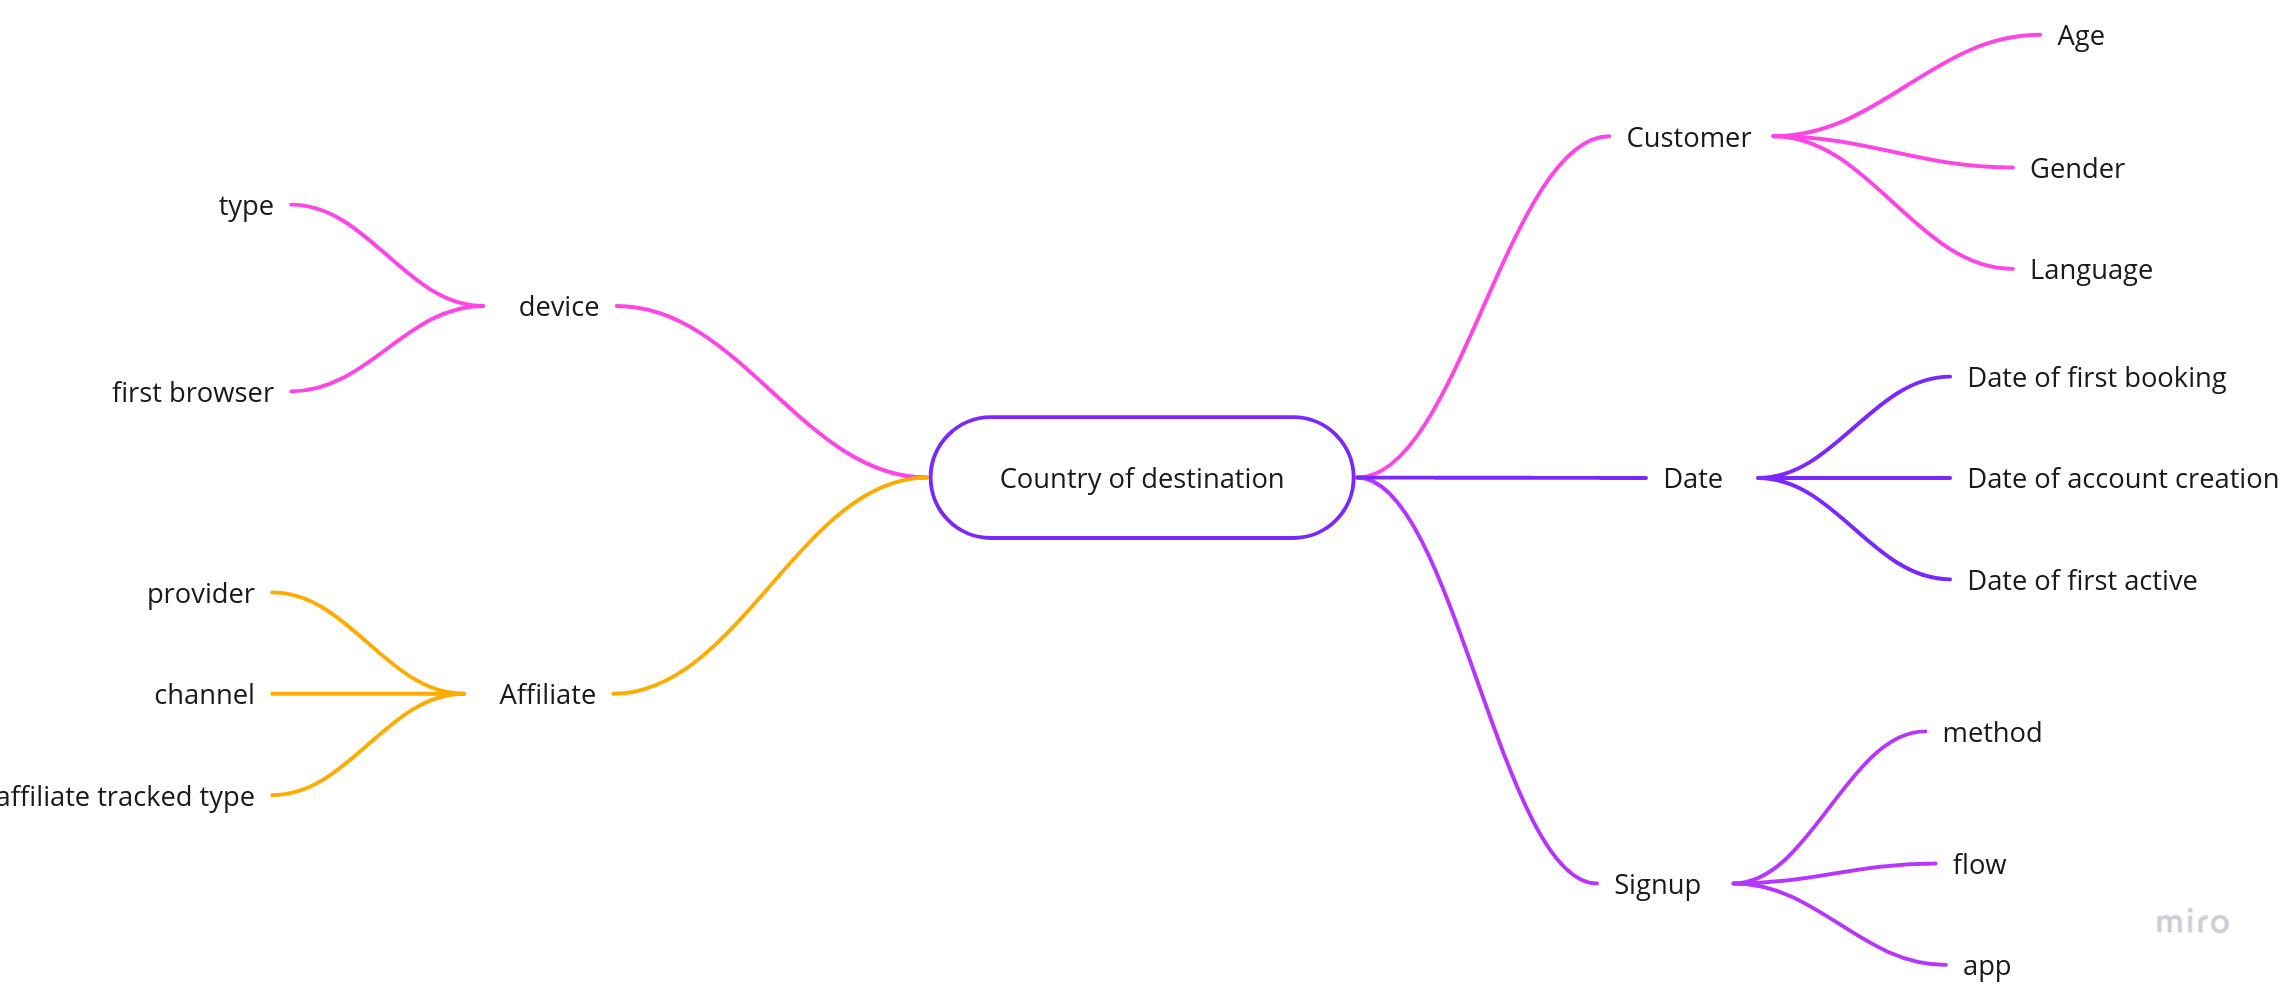

In [102]:
Image('mind_map.jpg')

### Customer Hypothesis
1. The proportion of man interested in travel to outside US is 15% higher than women.
2. The proportion of customers with more than 40 years old and booked to US is 10% higher than customers with less than 40 years old.
3. The proportion of customers with more than 30 years old and booked to outside US is 15% higher than customers with less than 30 years old.
4. The proportion of customers who use english language and booked to U.S is 20% higher than customers who traveled outside U.S

### Device Hypothesis
5. The proportion of users who use macbook and booked to U.S is 15% higher than users who booked to outside U.S
6. The proportion of users who use Android phone and booked to  U.S is 15% higher than users who use Iphone
7. The proportion of users who use Firefox and booked to outside U.S is 10% higher than users who use Google Chrome

### Affiliate Hypothesis
8. The proportion of users who came through SEO affilliate channel and booked outside U.S is 15% higher than users who came through remarketing.

### Signup Hypothesis
9. The proportion of users who singup through facebook and booked to U.S is 10% higher than user who booked to outside U.S
10. The proportion of users who signup directly and booked U.S is 15% higher than users who signup through google.

### Date Hypothesis
11. The average number of days to make the first booking after account creation for users who booked outside U.S is 15% higher than for users who booked to U.S
12. The proportion of customers who make their first booking in second semester and booked to outside U.S is 10% higher than who booked inside U.S.


## 4.2 Feature Engineering

In [9]:
#month and year of date account created
df3['year_account_created'] = df3['date_account_created'].dt.year
df3['month_account_created'] = df3['date_account_created'].dt.month

#month and year of first active
df3['year_first_active'] = df3['timestamp_first_active'].dt.year
df3['month_first_active'] = df3['timestamp_first_active'].dt.month

#month and year of first booking
df3['year_first_booking'] = df3['date_first_booking'].dt.year
df3['month_first_booking'] = df3['date_first_booking'].dt.month

#Difference in days between first active and first booking
df3['days_first_active_first_booking'] = (df3['date_first_booking'] - df3['timestamp_first_active']).dt.days

#Difference in weeks between first active and first booking
df3['weeks_first_active_first_booking'] = ((df3['date_first_booking'] - df3['timestamp_first_active'] ) // 7).dt.days

#Difference in months between first active and first booking
df3['months_first_active_first_booking'] = ((df3['date_first_booking'] - df3['timestamp_first_active'] ) // 30).dt.days

#Difference in days between first active and account creation
df3['days_first_active_account_created'] = (df3['date_account_created'] - df3['timestamp_first_active']).dt.days

#Difference in weeks between first active and account creation
df3['weeks_first_active_account_created'] = ((df3['date_account_created'] - df3['timestamp_first_active'] ) // 7).dt.days

#Difference in months between first active and account creation
df3['months_first_active_account_created'] = ((df3['date_account_created'] - df3['timestamp_first_active'] ) // 30).dt.days

#Time in days until first booking after creating account
df3['days_account_created_first_booking'] = (df3['date_first_booking'] - df3['date_account_created']).dt.days

#Time in weeks until first booking after creating account
df3['weeks_account_created_first_booking'] = ((df3['date_first_booking'] - df3['date_account_created'] ) // 7).dt.days

#Time in months until first booking after creating account
df3['months_account_created_first_booking'] = ((df3['date_first_booking'] - df3['date_account_created'] ) // 30).dt.days

# 5.0 Exploratory Data Analysis

In [10]:
df4 = df3.copy()

## 5.1 Univariate Analysis

### 5.1.1 Response Variable

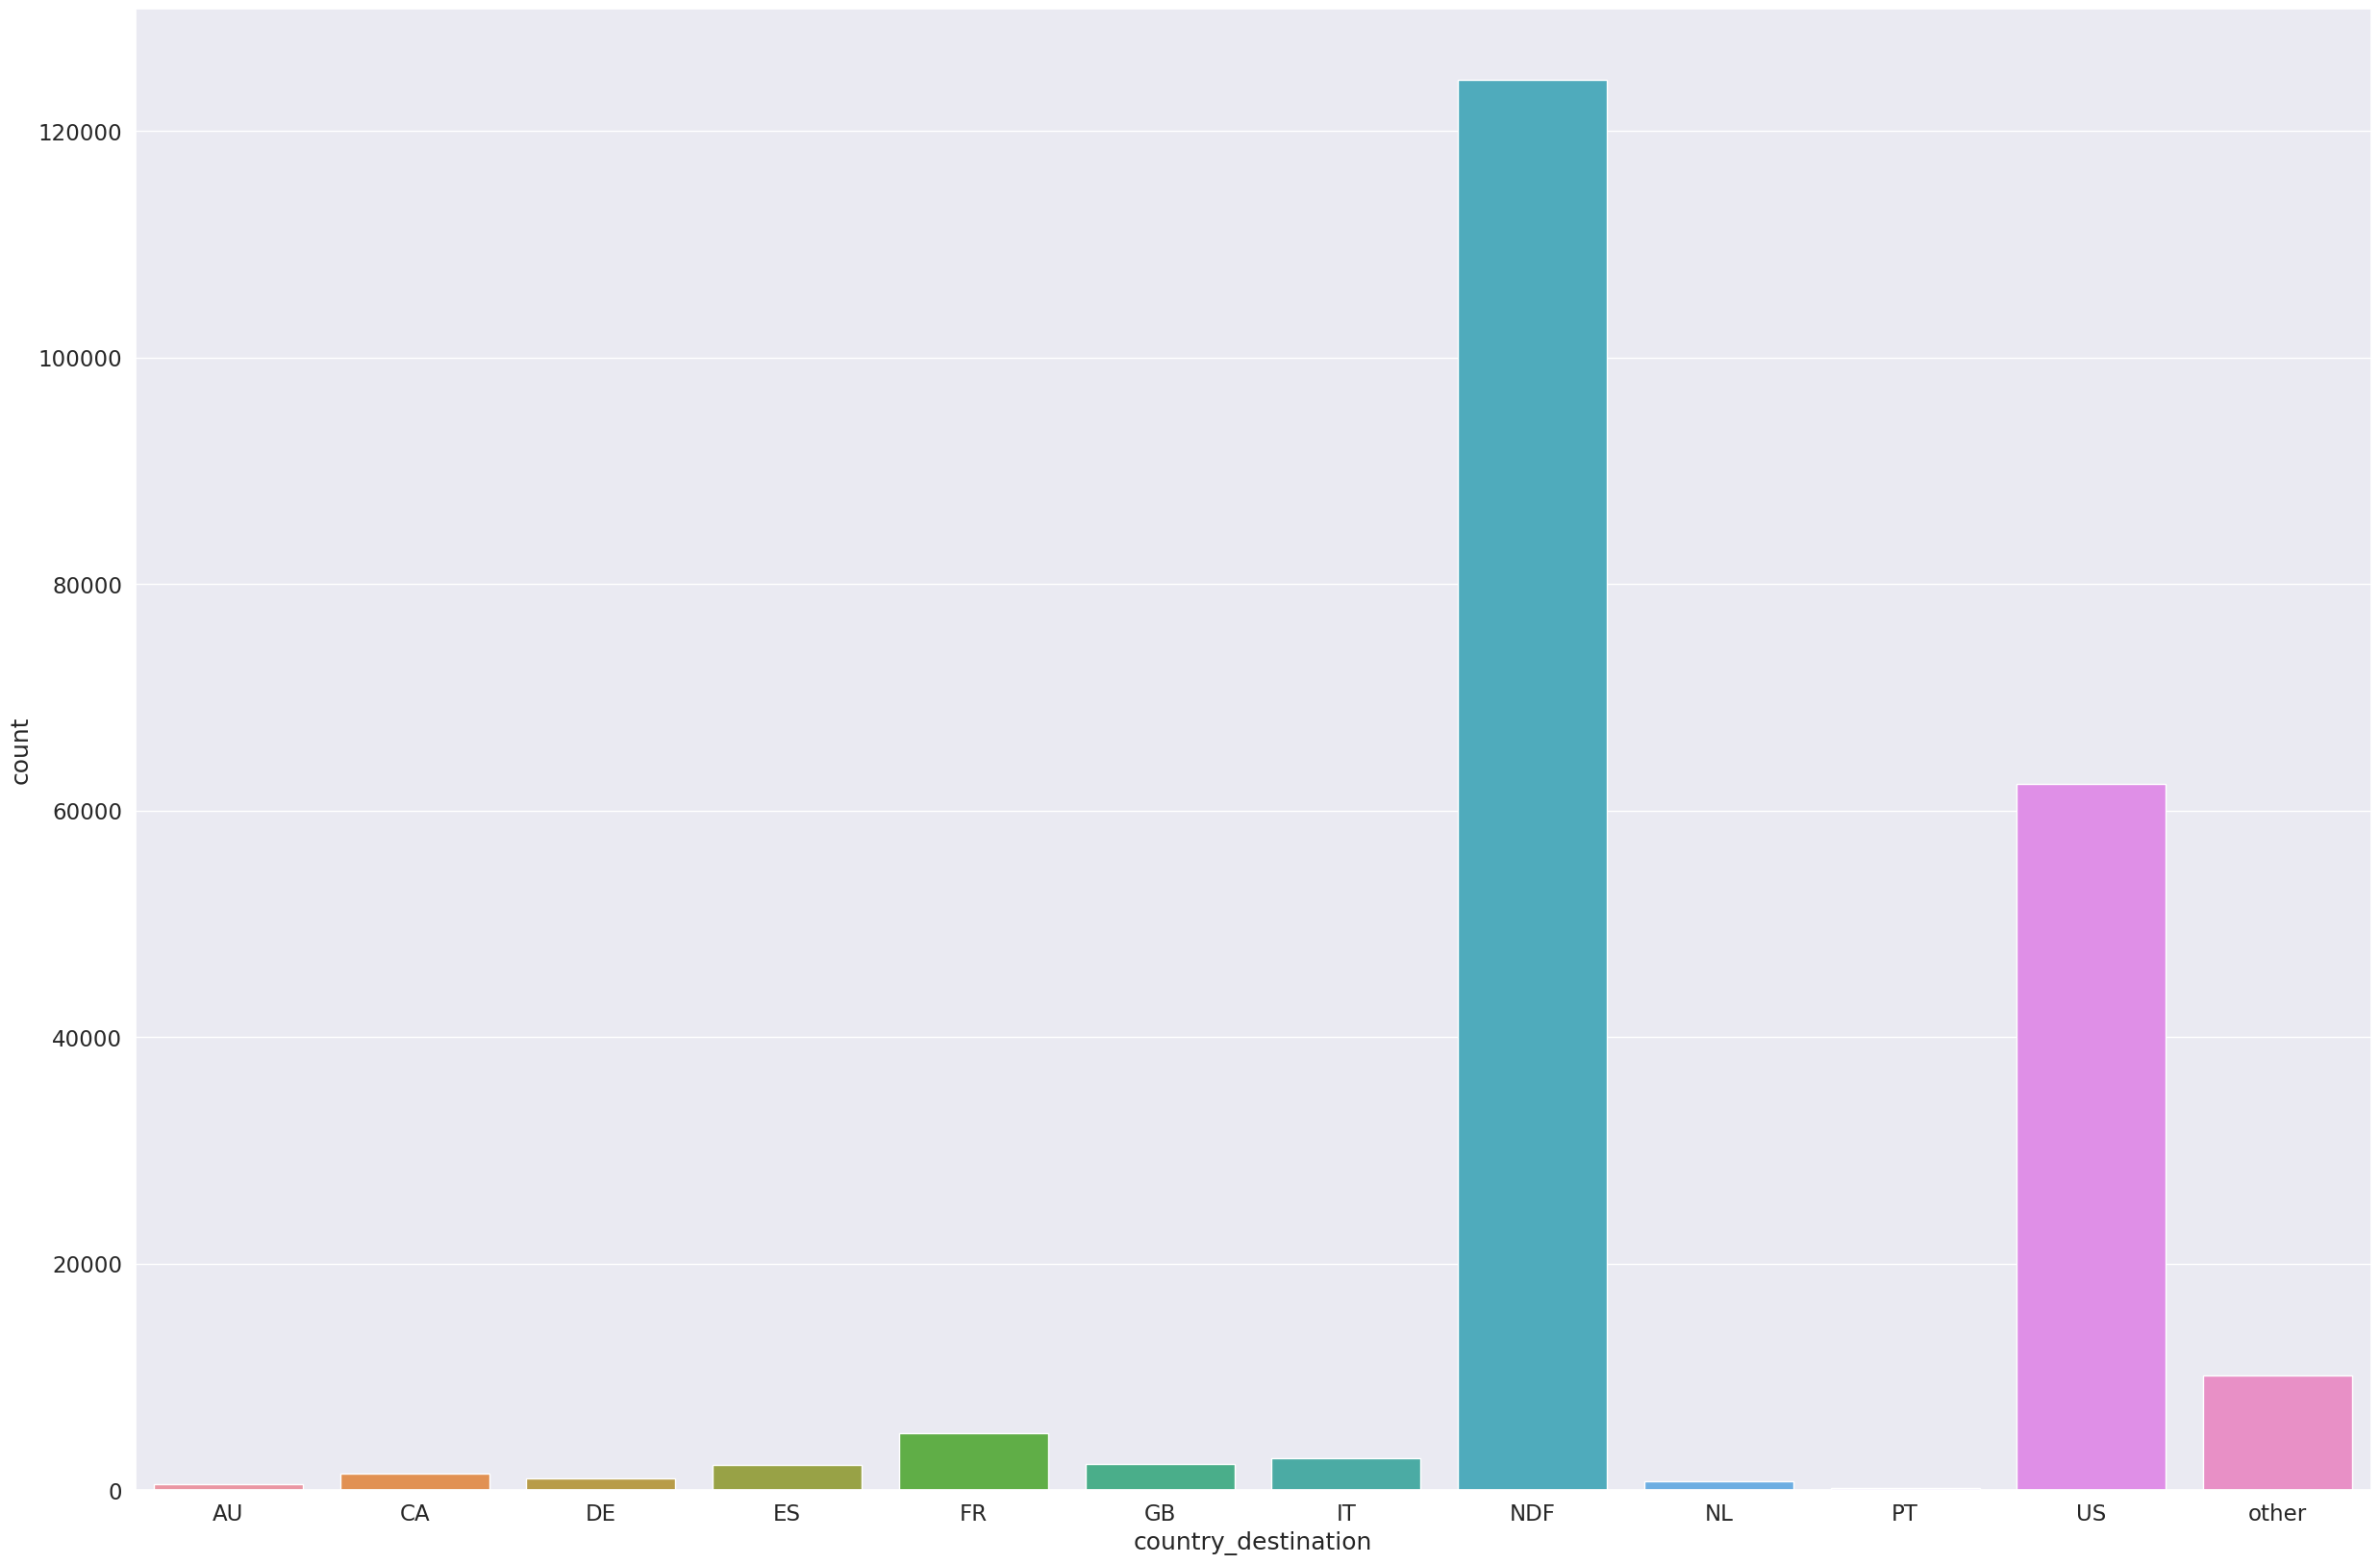

In [115]:
sns.countplot(x=df4['country_destination']);

### 5.1.2 Exploratory Variables

In [11]:
report = sv.analyze(df4.loc[:, df4.columns != 'id'])
report.show_html()

/home/dbcordeiro@sefaz.al.gov.br/anaconda3/envs/airbnb_predict_first_booking/lib/python3.11/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/home/dbcordeiro@sefaz.al.gov.br/anaconda3/envs/airbnb_predict_first_booking/lib/python3.11/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |      | [  0%]   00:00 -> (? left)

/home/dbcordeiro@sefaz.al.gov.br/anaconda3/envs/airbnb_predict_first_booking/lib/python3.11/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/home/dbcordeiro@sefaz.al.gov.br/anaconda3/envs/airbnb_predict_first_booking/lib/python3.11/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/home/dbcordeiro@sefaz.al.gov.br/anaconda3/envs/airbnb_predict_first_booking/lib/python3.11/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/home/dbcordeiro@sefaz.al.gov.b

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [16]:
df4.drop(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'], axis=1)

,country_destination,year_account_created,month_account_created,year_first_active,month_first_active,year_first_booking,month_first_booking,days_first_active_first_booking,weeks_first_active_first_booking,months_first_active_first_booking,days_first_active_account_created,weeks_first_active_account_created,months_first_active_account_created,days_account_created_first_booking,weeks_account_created_first_booking,months_account_created_first_booking
0,NDF,2010,6,2009,3,2010,6,466,66,15,466,66,15,0,0,0
1,NDF,2011,5,2009,5,2011,5,732,104,24,732,104,24,0,0,0
2,US,2010,9,2009,6,2010,8,419,59,13,476,68,15,-57,-9,-2
3,other,2011,12,2009,10,2012,9,1043,149,34,765,109,25,278,39,9
4,US,2010,9,2009,12,2010,2,72,10,2,280,40,9,-208,-30,-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,NDF,2014,6,2014,6,2014,6,0,0,0,0,0,0,0,0,0
213447,NDF,2014,6,2014,6,2014,6,0,0,0,0,0,0,0,0,0
213448,NDF,2014,6,2014,6,2014,6,0,0,0,0,0,0,0,0,0
213449,NDF,2014,6,2014,6,2014,6,0,0,0,0,0,0,0,0,0


In [15]:
report_new_features = sv.analyze(df4.drop(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'], axis=1))
report_new_features.show_html()

/home/dbcordeiro@sefaz.al.gov.br/anaconda3/envs/airbnb_predict_first_booking/lib/python3.11/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/home/dbcordeiro@sefaz.al.gov.br/anaconda3/envs/airbnb_predict_first_booking/lib/python3.11/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |      | [  0%]   00:00 -> (? left)

/home/dbcordeiro@sefaz.al.gov.br/anaconda3/envs/airbnb_predict_first_booking/lib/python3.11/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/home/dbcordeiro@sefaz.al.gov.br/anaconda3/envs/airbnb_predict_first_booking/lib/python3.11/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/home/dbcordeiro@sefaz.al.gov.br/anaconda3/envs/airbnb_predict_first_booking/lib/python3.11/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/home/dbcordeiro@sefaz.al.gov.br/anaconda3/envs/airbnb_predict_first_booking/lib/python3.11/sit

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 5.2 Bivariate Analysis

### Customer Hypothesis
1. The proportion of man interested in travel to outside US is 15% higher than women.
2. The proportion of customers with more than 40 years old and booked to US is 10% higher than customers with less than 40 years old.
3. The proportion of customers with more than 30 years old and booked to outside US is 15% higher than customers with less than 30 years old.
4. The proportion of customers who use english language and booked to U.S is 20% higher than customers who booked to outside U.S

### Device Hypothesis
5. The proportion of users who use macbook in their first booking and booked to U.S is 15% higher than users who booked to outside U.S
6. The proportion of users who use Android phone and booked to  U.S is 15% higher than users who use Iphone
7. The proportion of users who use Firefox and booked to outside U.S is 10% higher than users who use Google Chrome

### Affiliate Hypothesis
8. The proportion of users who came through SEO affilliate channel and booked outside U.S is 15% higher than users who came through remarketing.

### Signup Hypothesis
9. The proportion of users who singup through facebook and booked to U.S is 10% higher than user who booked to outside U.S
10. The proportion of users who signup directly and booked U.S is 15% higher than users who signup through google.

### Date Hypothesis
11. The average number of days to make the first booking after account creation for users who booked outside U.S is 15% higher than for users who booked to U.S
12. The proportion of customers who make their first booking in second semester and booked to outside U.S is 10% higher than who booked inside U.S.

In [12]:
df4_outside_US= df4[ (df4['country_destination'] != 'NDF') &  (df4['country_destination'] != 'US') & (df4['gender'] != '-unknown-')  ] 
df4_US = df4[ (df4['country_destination'] == 'US') & (df4['gender'] != '-unknown-') ] 

### H1. The proportion of man who made his first booking to outside US is 15% higher than women proportions.

The P-Value of the ChiSq Test is: 1.2009085995864805e-33
country_destination   AU   CA   DE    ES    FR    GB    IT   NL   PT  other    All
gender                                                                            
FEMALE               207  455  358   853  1962   881  1091  254   78   3160   9299
MALE                 188  477  416   677  1335   682   699  278   69   3443   8264
All                  395  932  774  1530  3297  1563  1790  532  147   6603  17563


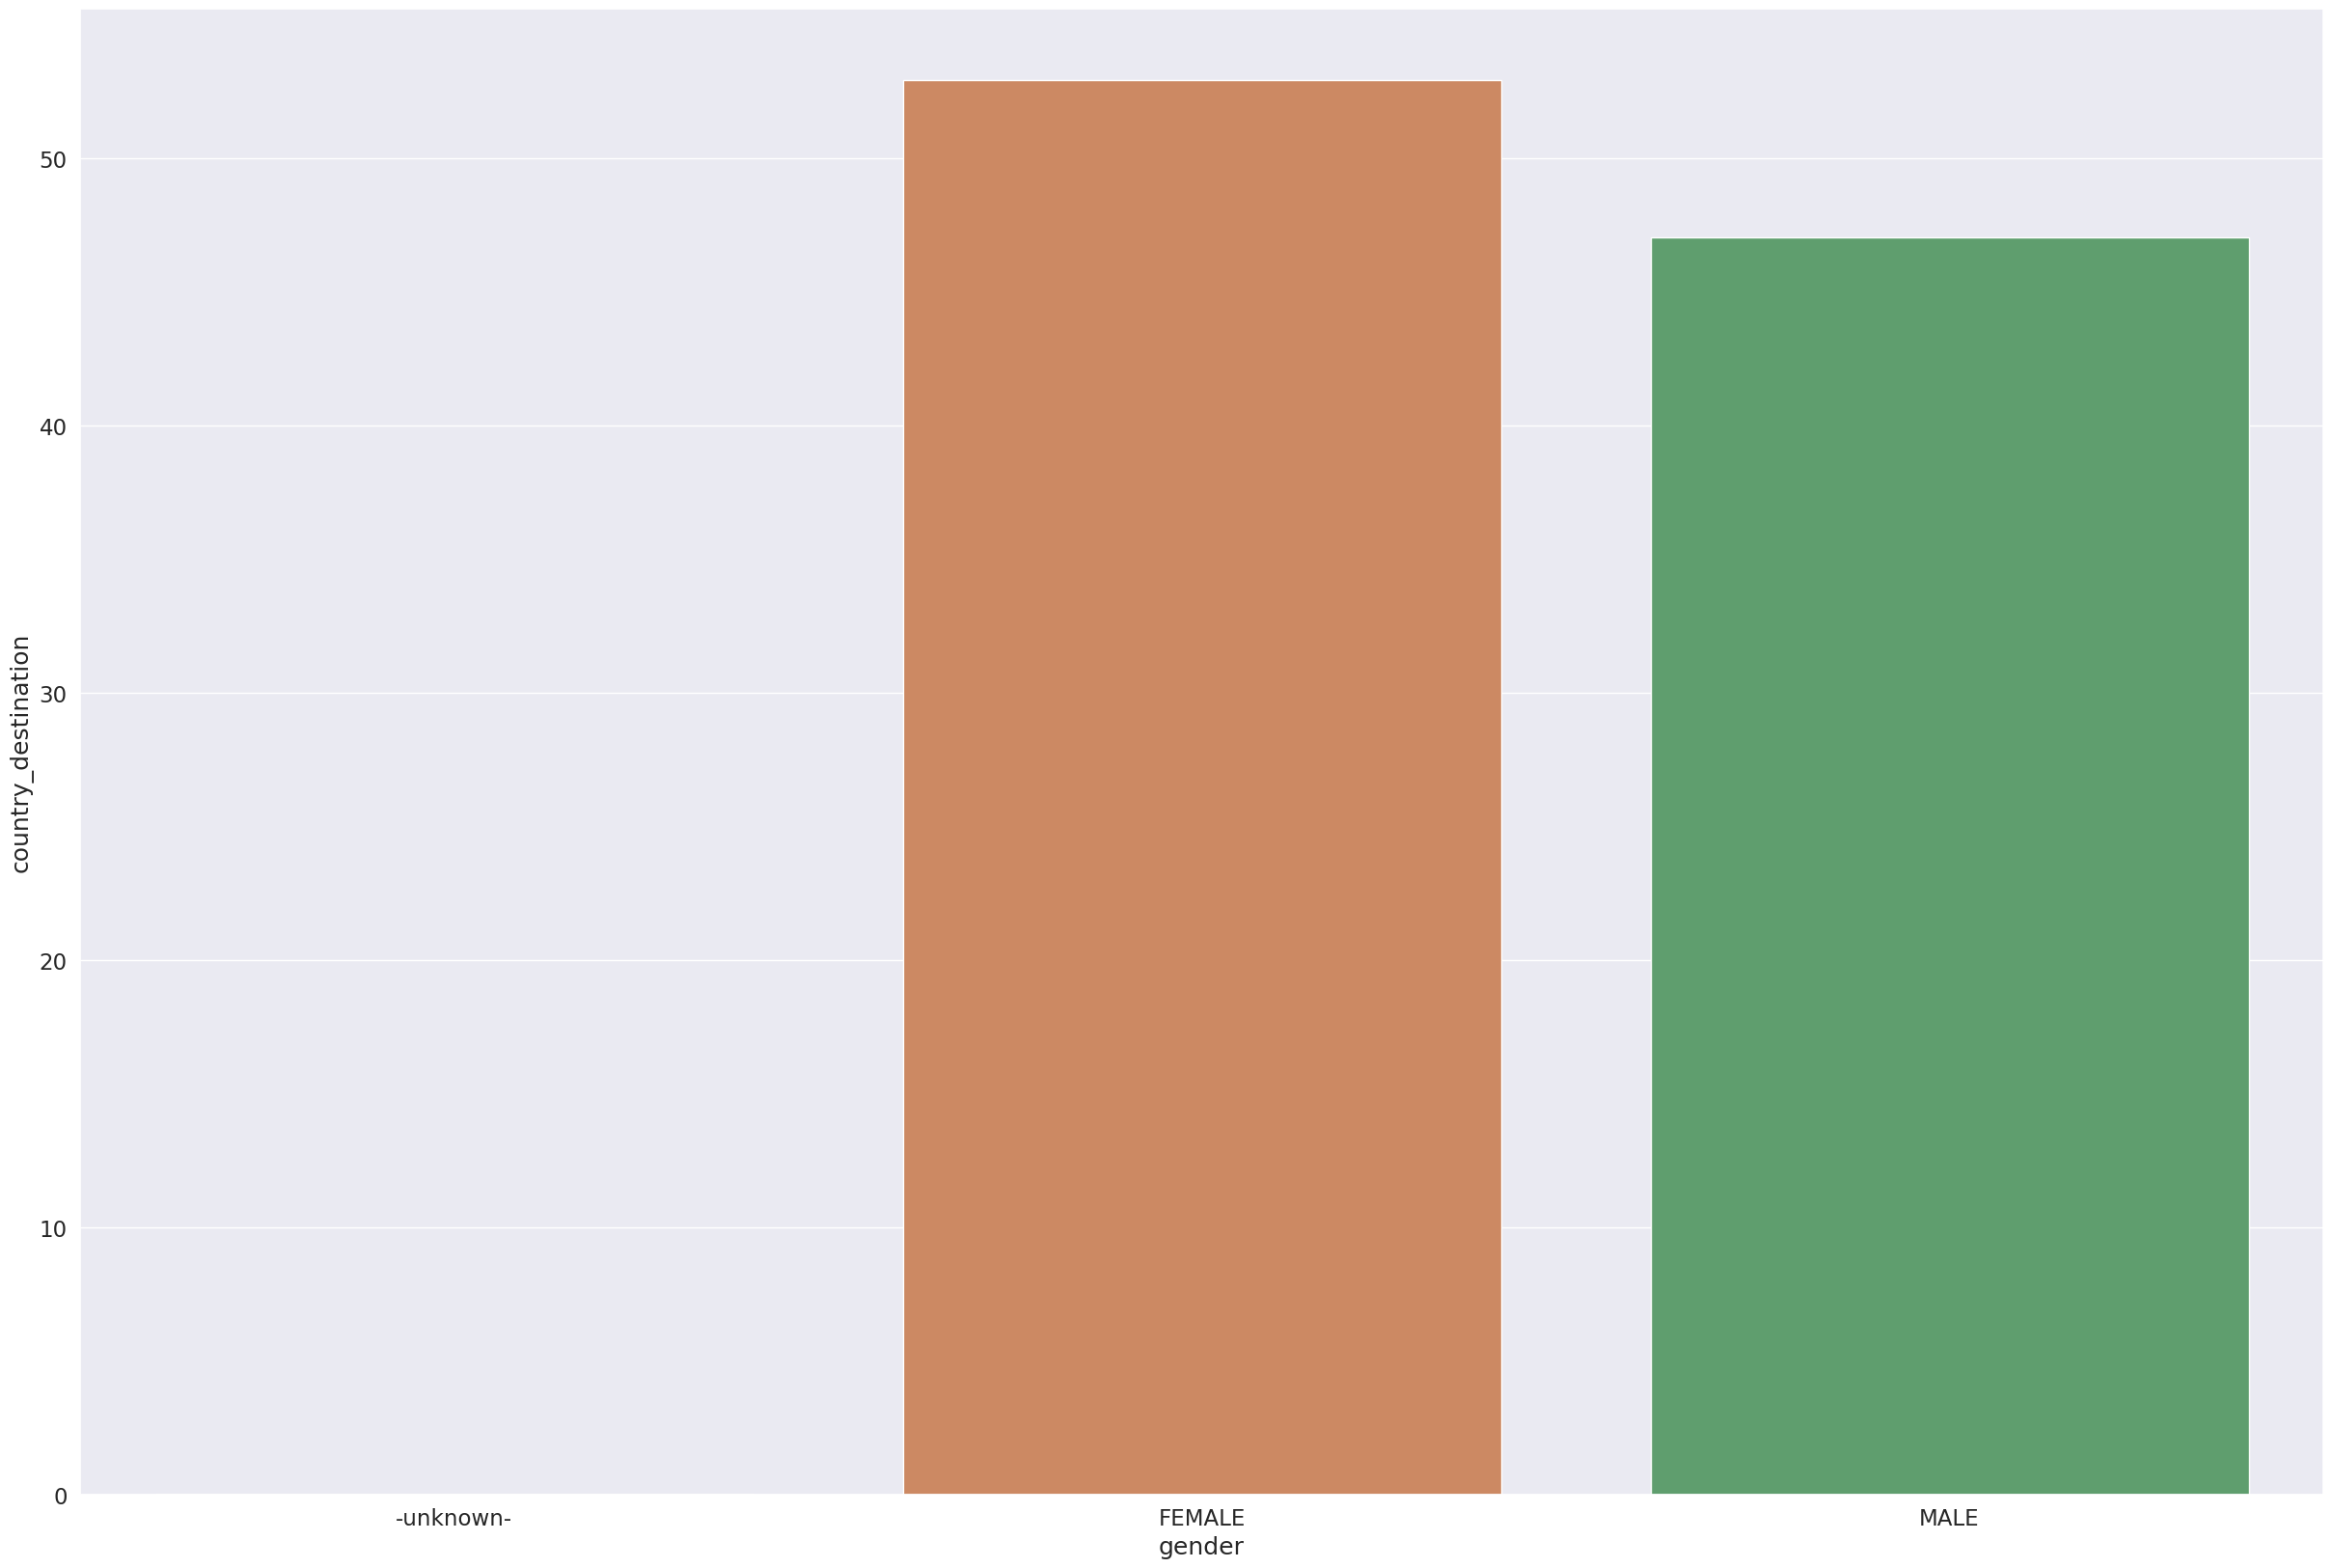

In [231]:
df4_aux1 = df4_outside_US[ ['country_destination','gender'] ].groupby('gender').count().apply(lambda x: np.round(x*100/x.sum(), 2) )
df4_aux2 = pd.crosstab(index=df4_outside_US['gender'], columns=df4_outside_US['country_destination'], margins=True)
chisquared_test = chi2_contingency(df4_aux2)
sns.barplot(y='country_destination',x='gender', data=df4_aux1.reset_index());
print('The P-Value of the ChiSq Test is:', chisquared_test[1])
print(df4_aux2)

False. In fact, the proportion of women who made her first booking to outside U.S is 53% against 47% of men. So the proportion of women is 10% higher. The chi-squared test show no independencies between features

### H2. The proportion of customers with more than 40 years old and booked to US is 10% higher than customers with more than 40 years old and booked to outside U.S.

,proportion,country_destination
0,0.25,Outside_US
1,0.23,US


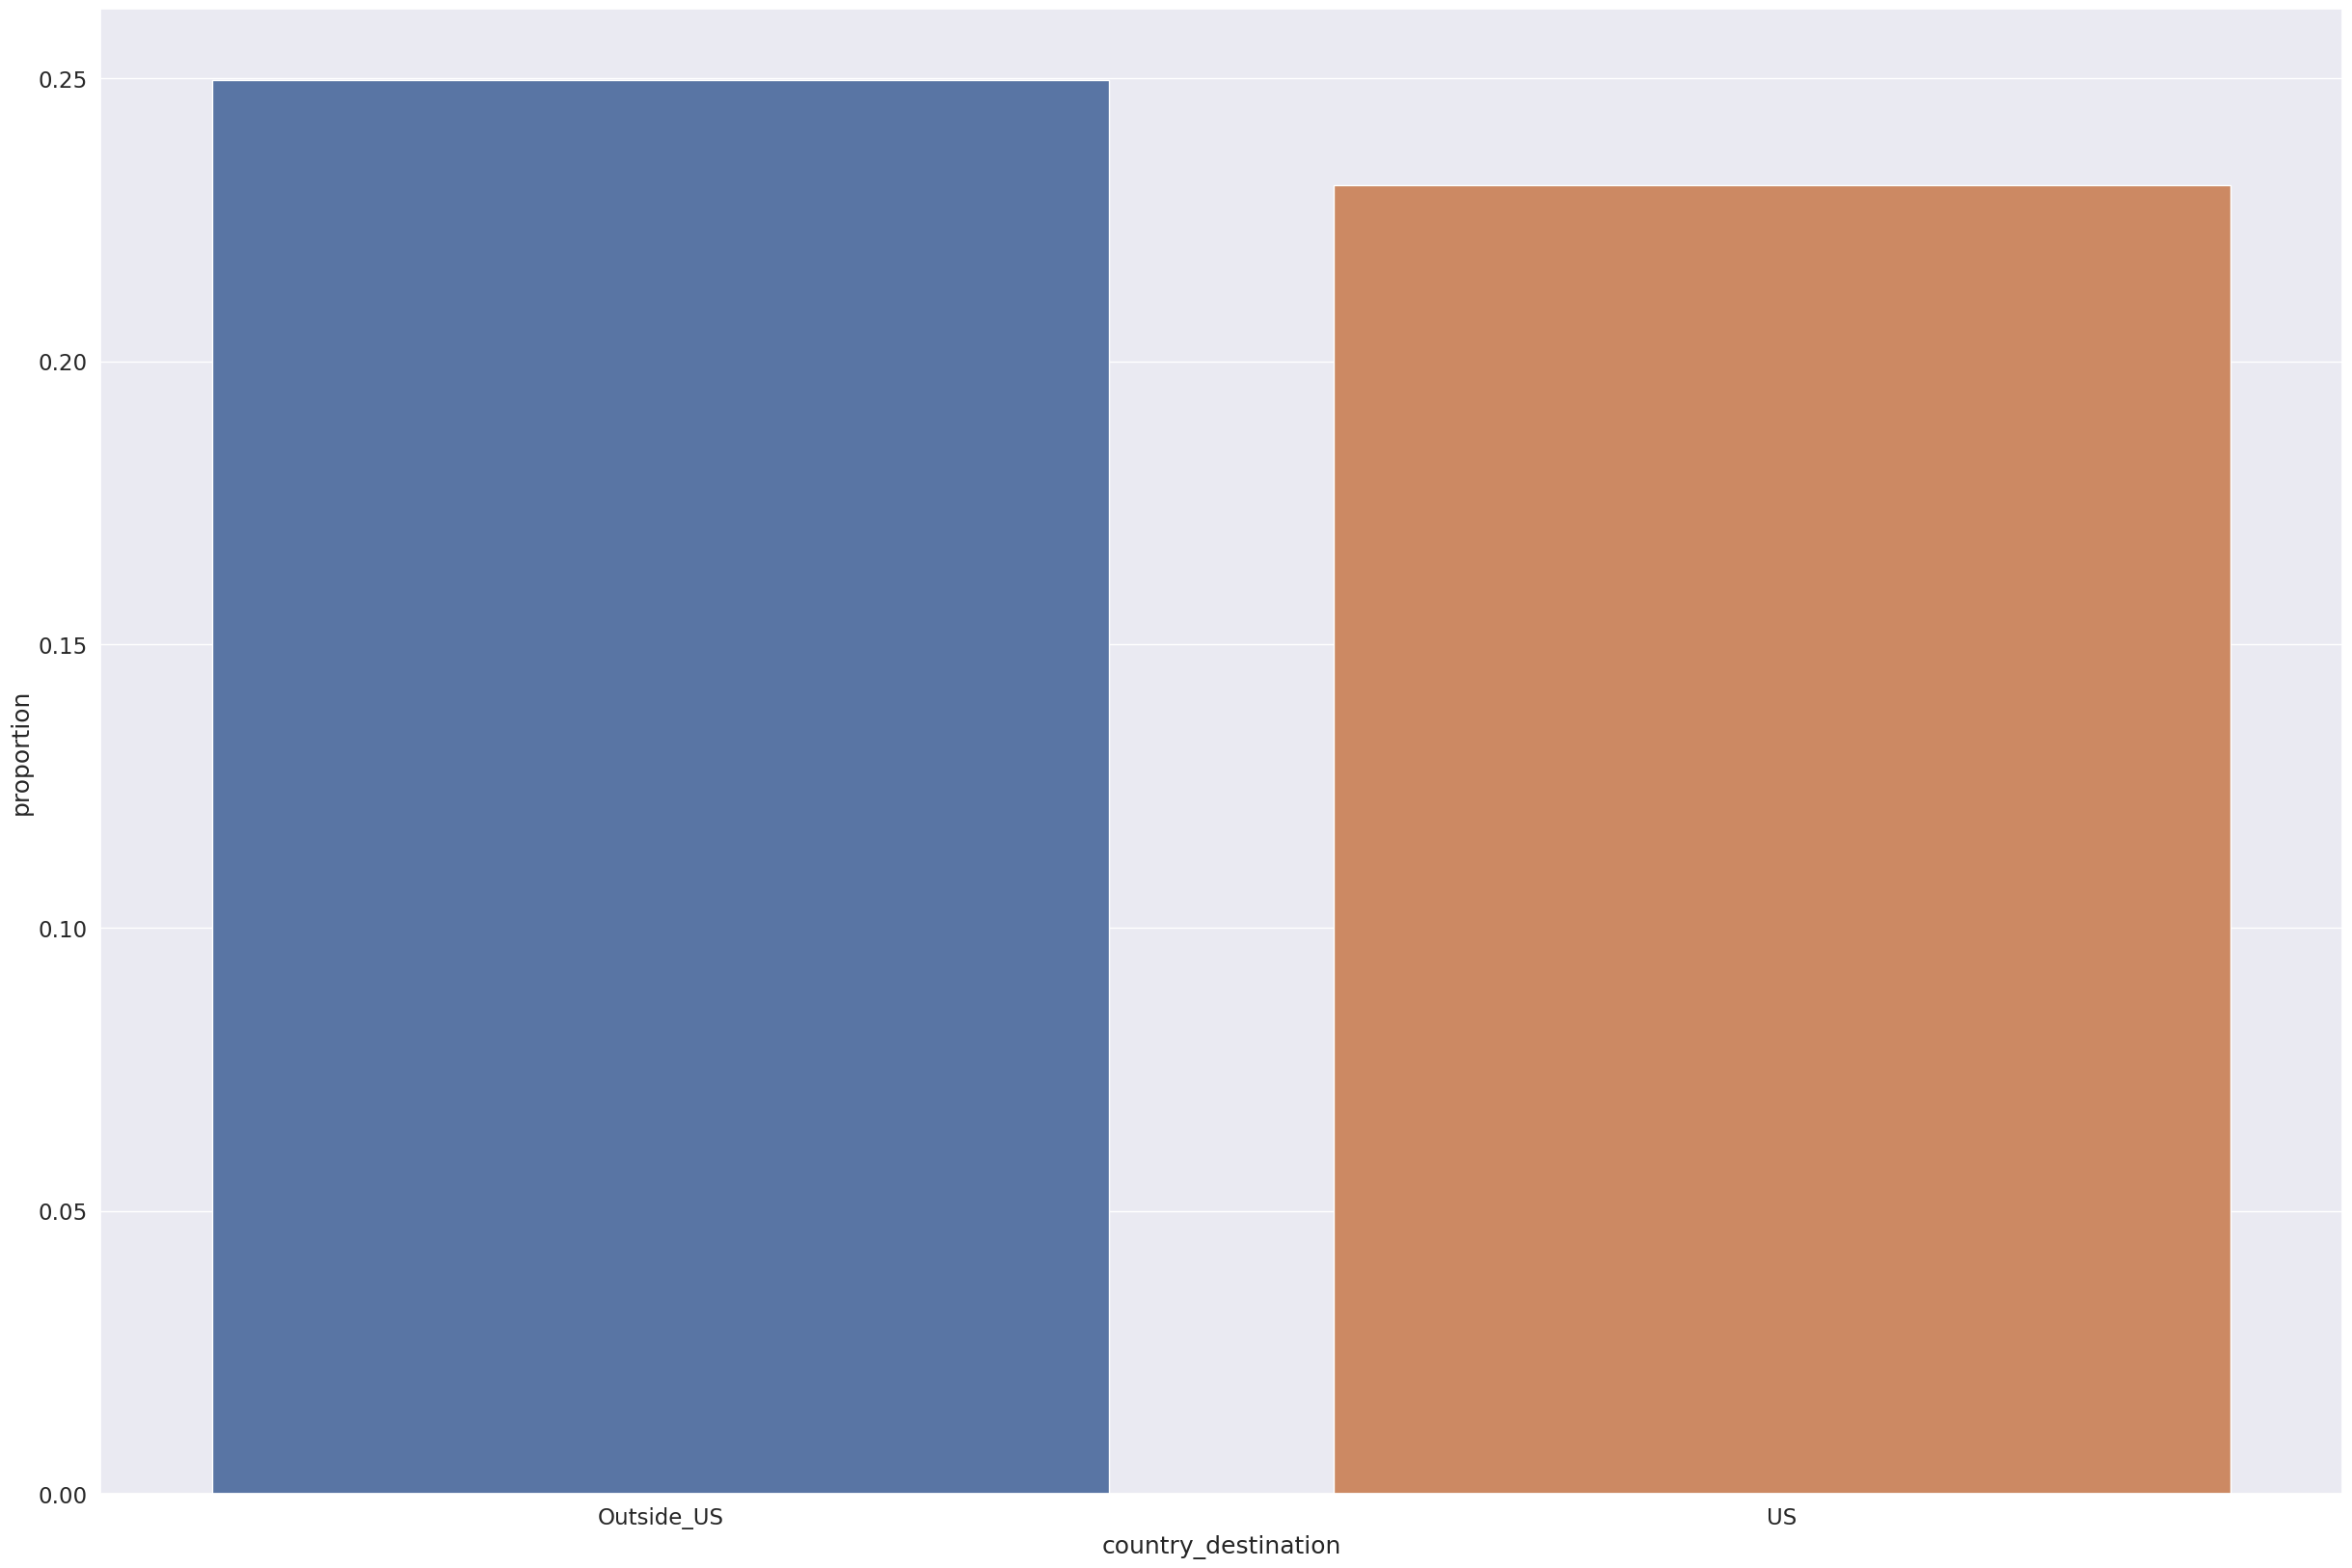

In [58]:
df4_aux1 = pd.DataFrame({'proportion':[df4_outside_US[df4_outside_US['age'] > 40]['age'].count() / len(df4_outside_US), df4_US[df4_US['age'] > 40]['age'].count() / len(df4_US) ], 'country_destination': ['Outside_US', 'US'] } )
sns.barplot(x='country_destination', y='proportion', data=df4_aux1);
df4_aux1

False. Actually the proportion of customers with more than 40 years old and booked to U.S is 9% lesser than customers with more than 40 years old and booked outside U.S.

### H4. The proportion of customers who use english language and booked to U.S is 20% higher than customers who booked to outside U.S

,proportion,country_destination
0,0.97,Outside_US
1,0.97,US


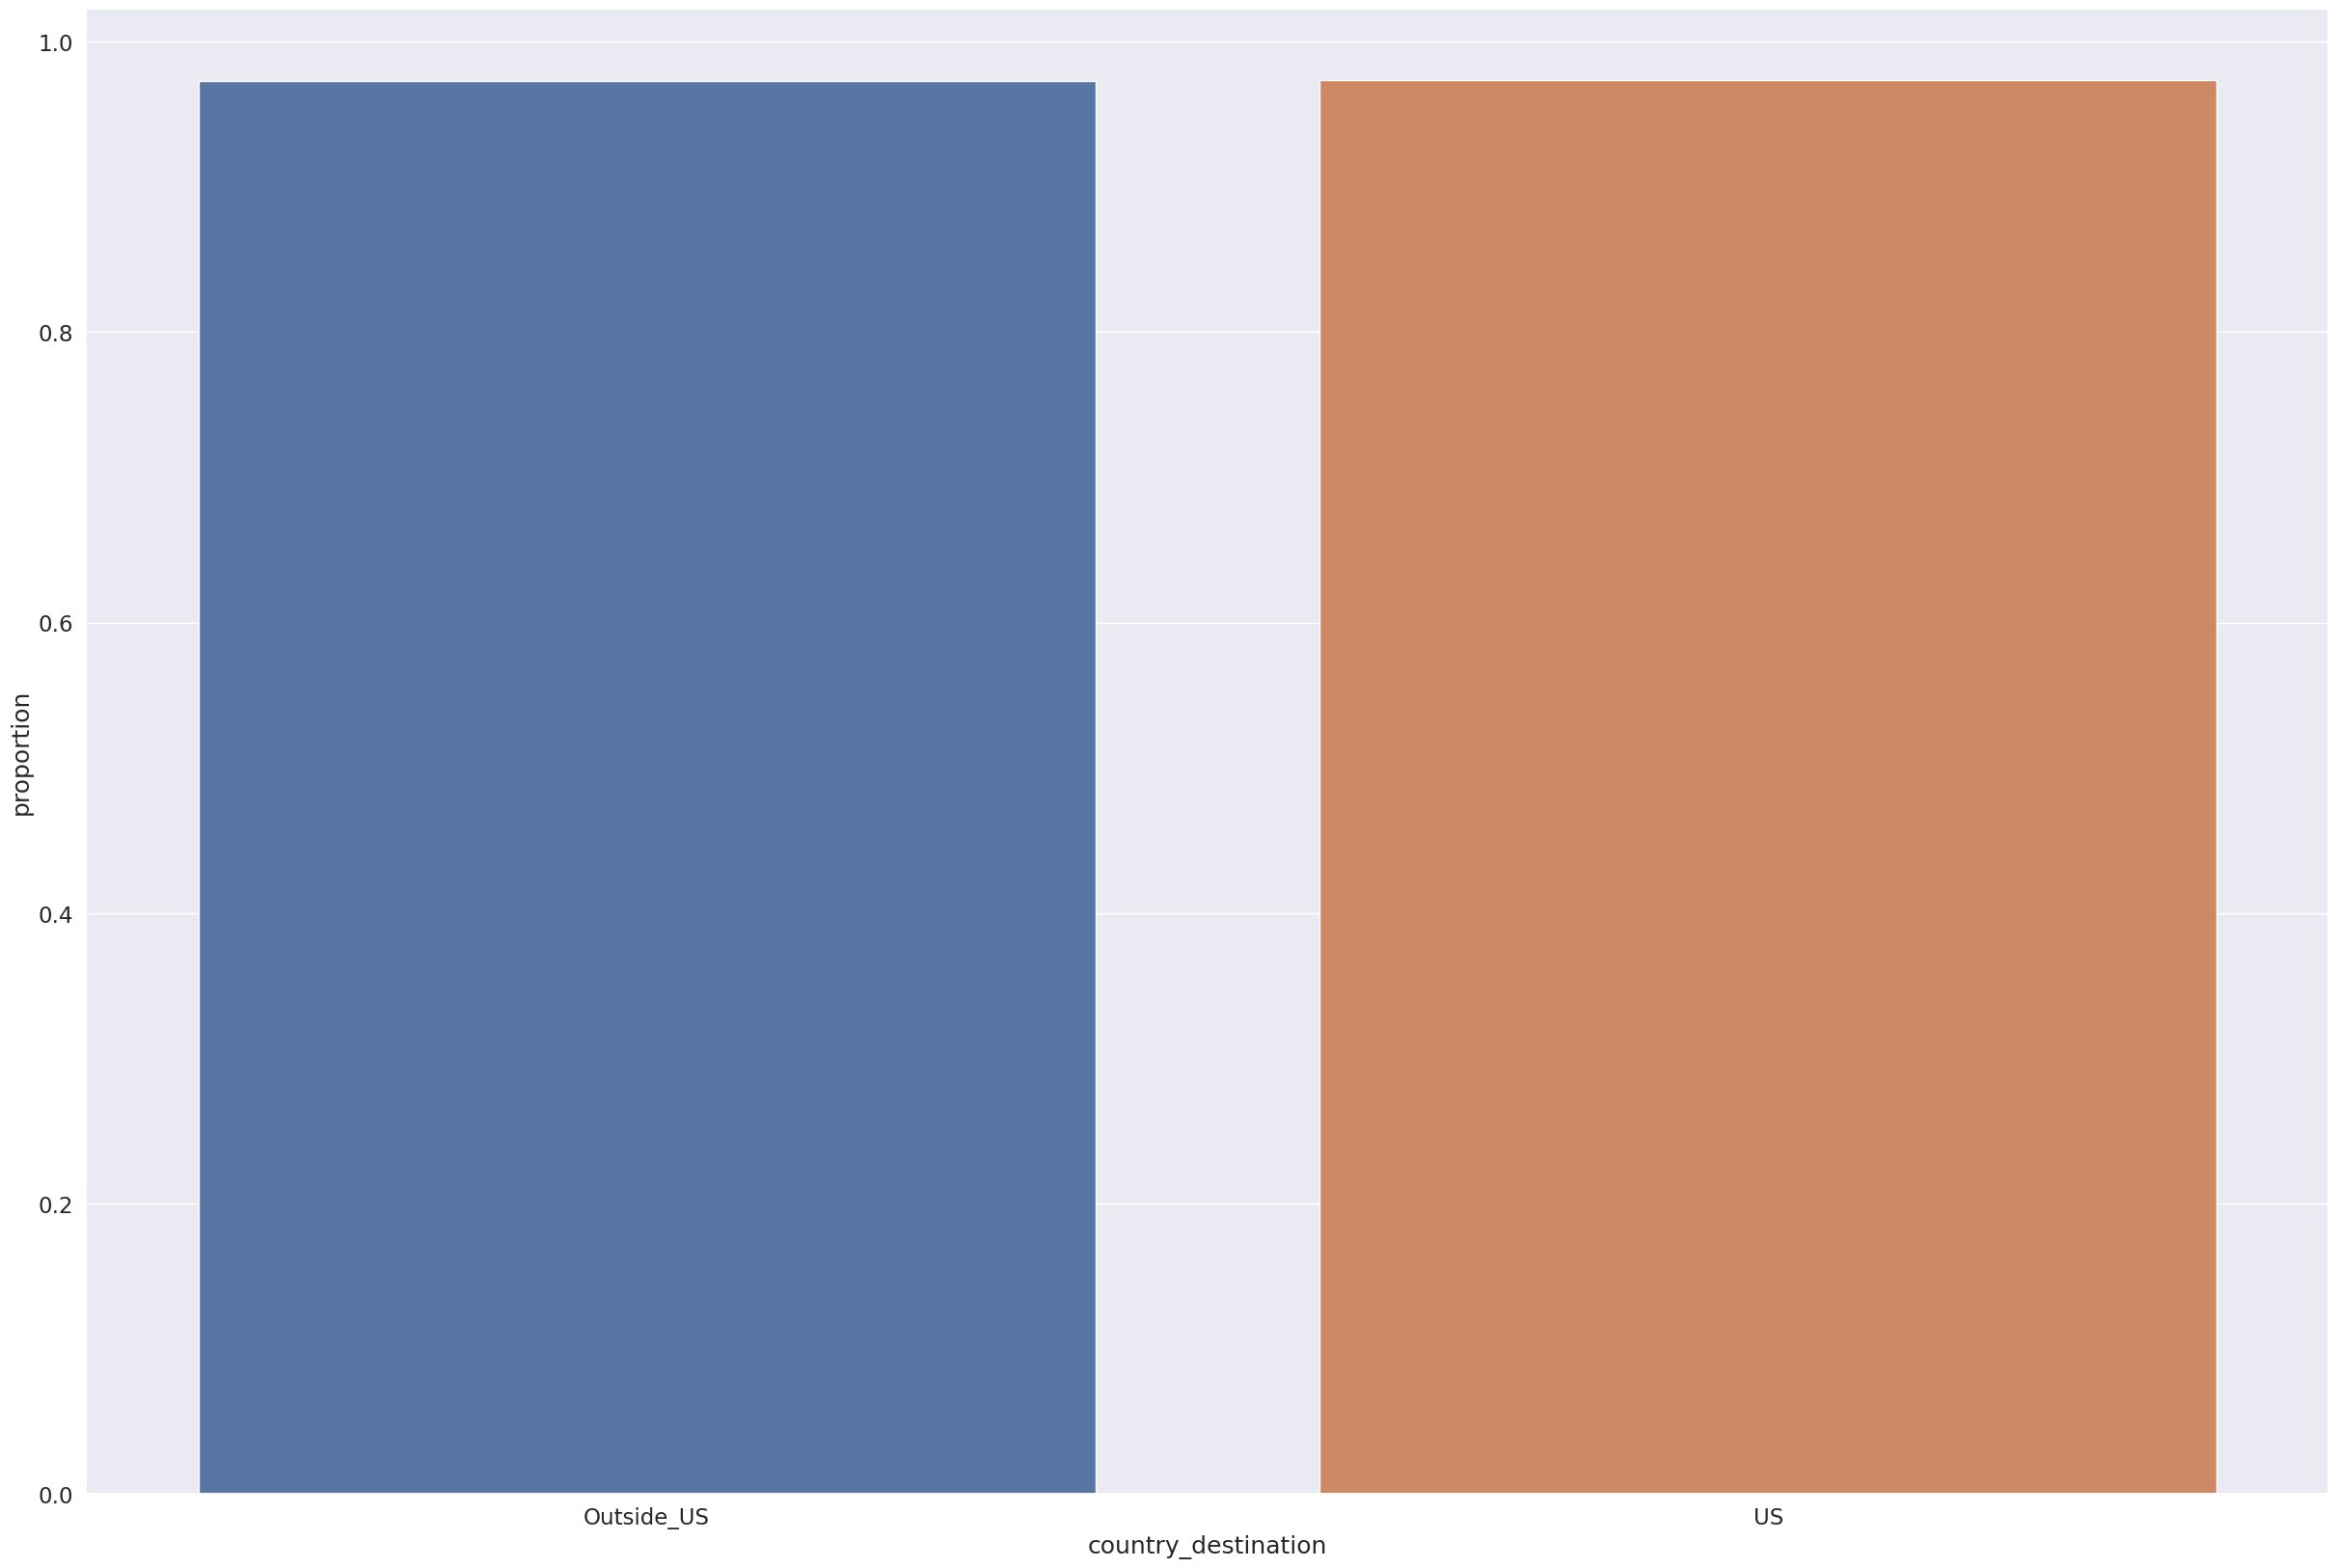

In [59]:
df4_aux1 = pd.DataFrame({'proportion':[df4_outside_US[df4_outside_US['language'] == 'en']['language'].count() / len(df4_outside_US), df4_US[df4_US['language'] == 'en']['language'].count() / len(df4_US) ], 'country_destination': ['Outside_US', 'US'] } )
sns.barplot(x='country_destination', y='proportion', data=df4_aux1);
df4_aux1

False. The proportion is exactly the same.

### H5. The proportion of users who use macbook in their first booking and booked to U.S is 15% higher than users who booked to outside U.S

,proportion,country_destination
0,0.50,Outside_US
1,0.50,US


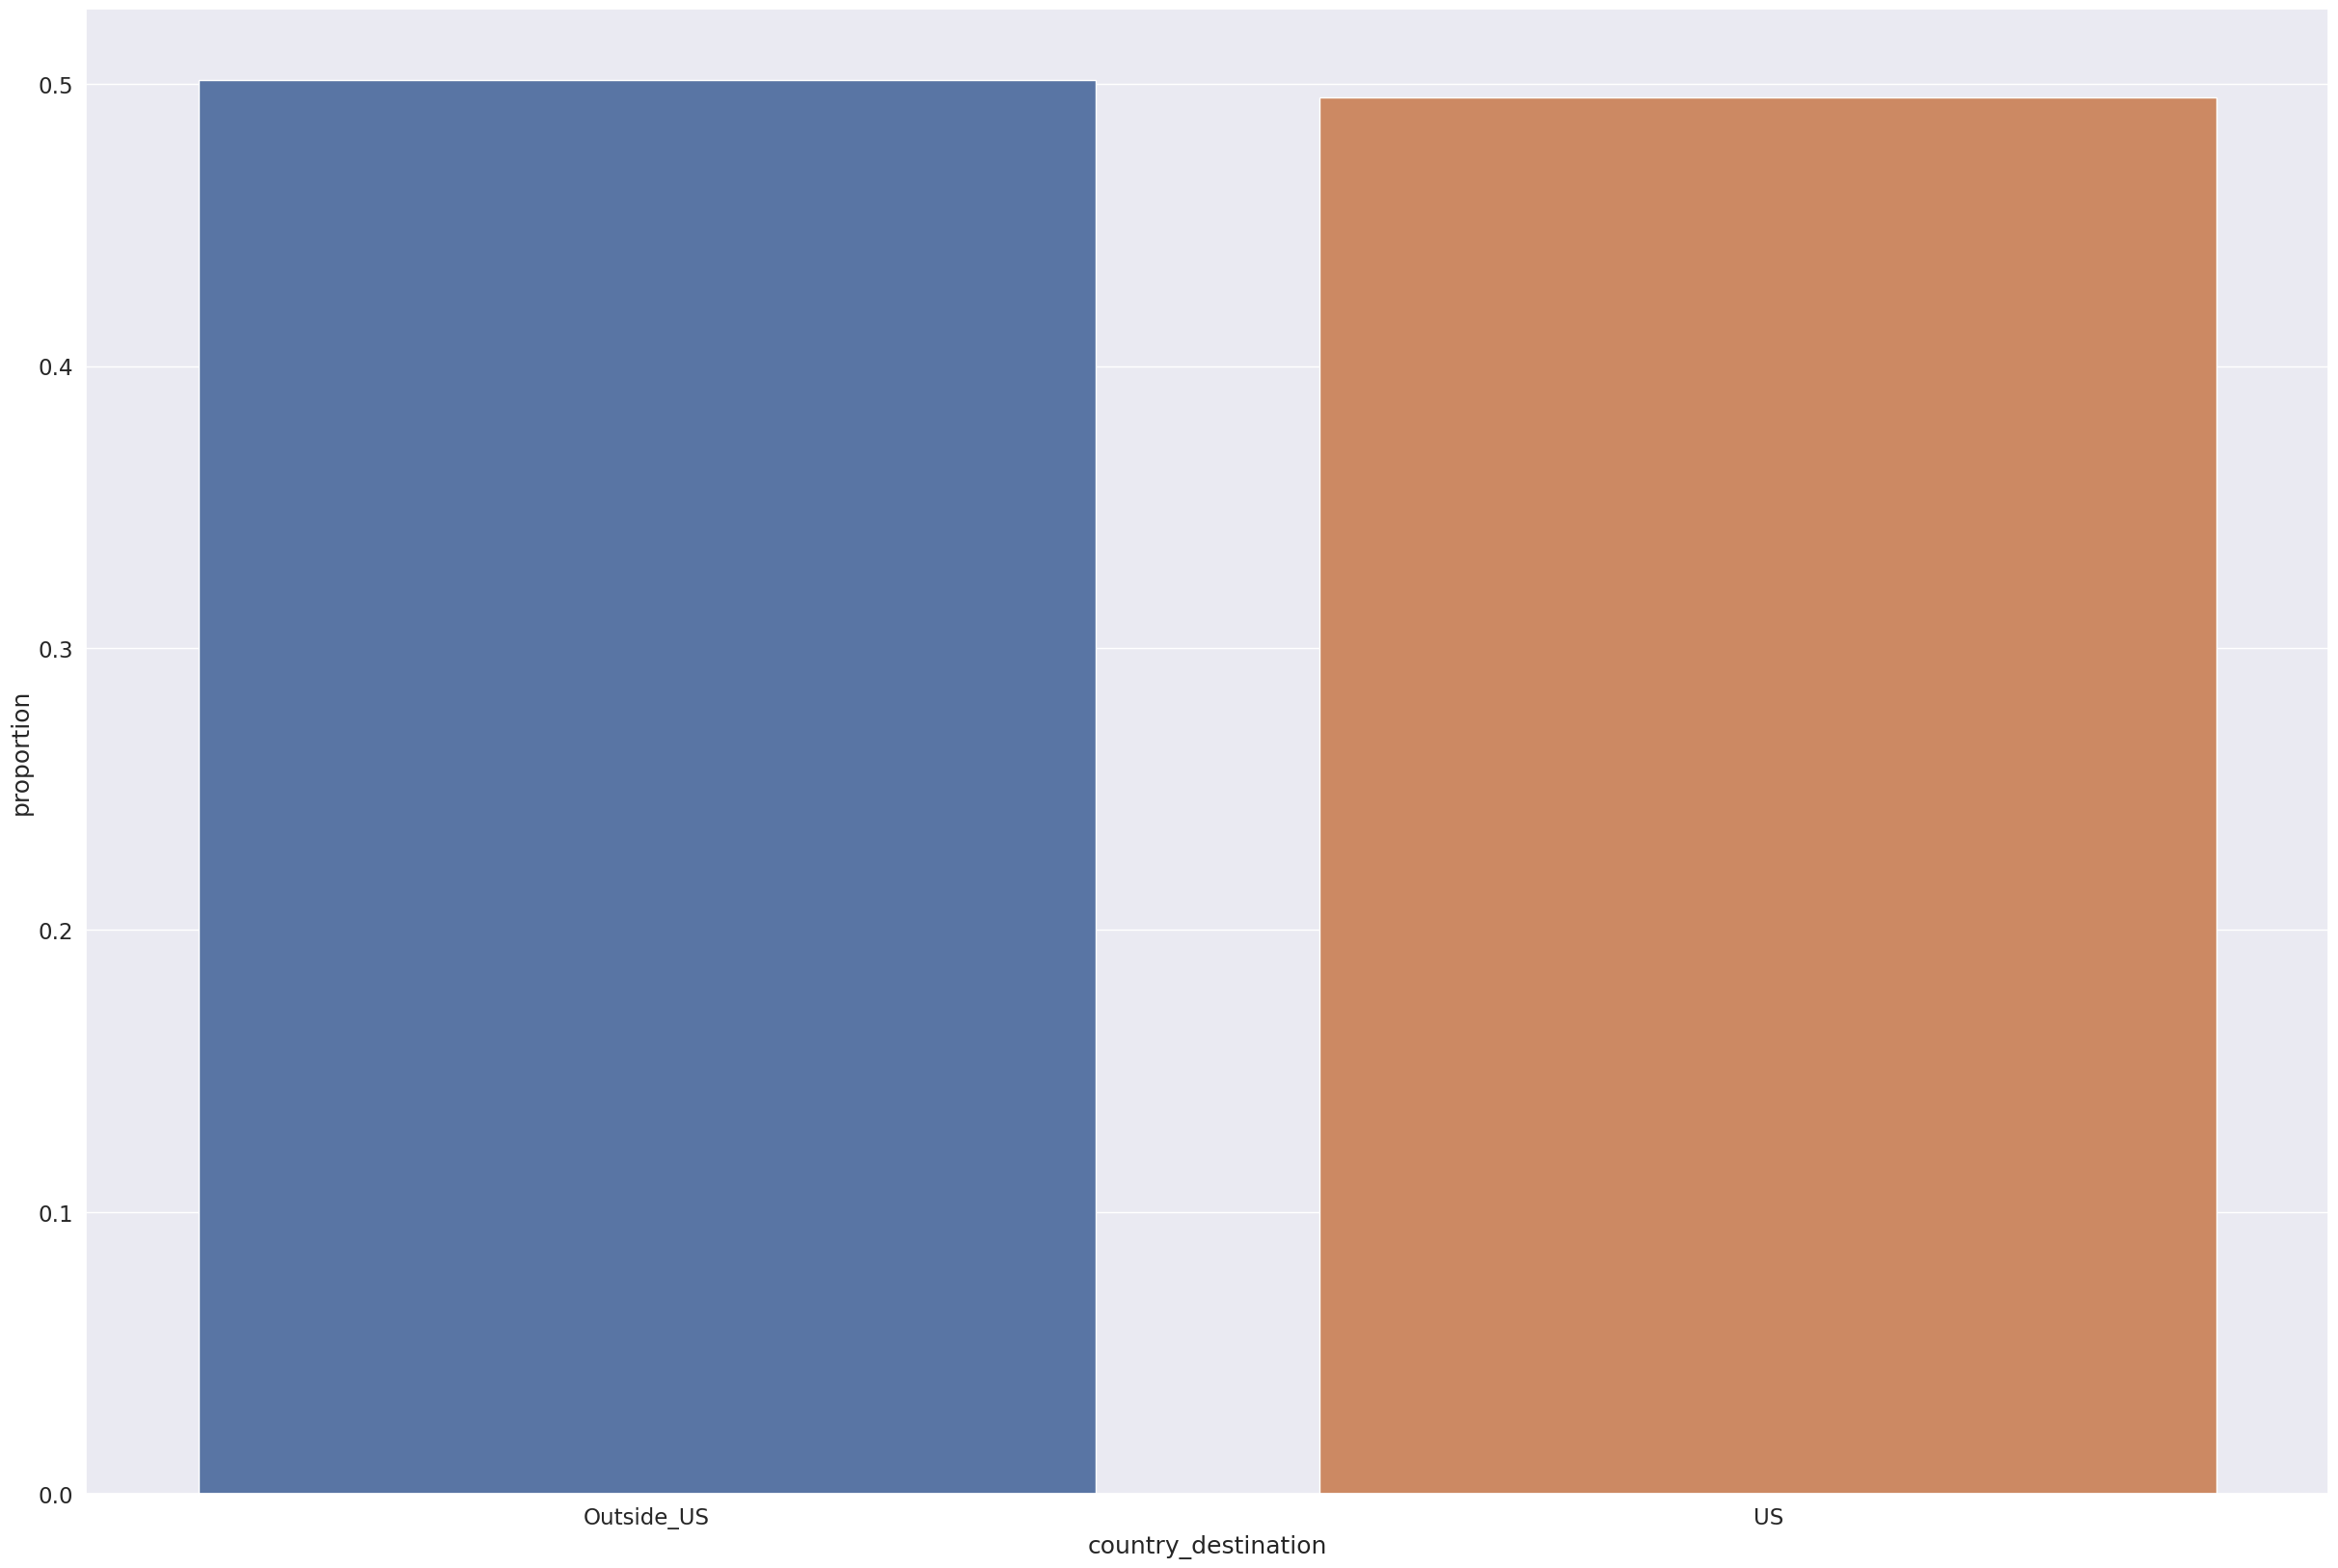

In [62]:
df4_aux1 = pd.DataFrame({'proportion':[df4_outside_US[df4_outside_US['first_device_type'] == 'Mac Desktop']['first_device_type'].count() / len(df4_outside_US), df4_US[df4_US['first_device_type'] == 'Mac Desktop']['first_device_type'].count() / len(df4_US) ], 'country_destination': ['Outside_US', 'US'] } )
sns.barplot(x='country_destination', y='proportion', data=df4_aux1);
df4_aux1

False. The proportion is the same. 

### H6. The proportion of users who use Android phone and booked to U.S is 15% higher than users who use Iphone

In [ ]:
df4_aux1 = df4_US[['first_device_type', 'id']].groupby('first_device_type').count() / len(df4_US)
sns.barplot(x='first_device_type', y='id', data=df4_aux1.reset_index());
df4_aux1.reset_index()

False. The proportion of customers who use Android Phone as first device when booking and booked to U.S is just 1% while customers who use Iphone is 8%.


### H7. The proportion of customers who use Firefox and booked to outside U.S is 10% higher than users who use Google Chrome

In [ ]:
df4_aux1 = pd.DataFrame({'proportion':[df4_outside_US[df4_outside_US['first_browser'] == 'Firefox']['first_browser'].count() / len(df4_outside_US), df4_outside_US[df4_outside_US['first_browser'] == 'Chrome']['first_browser'].count() / len(df4_outside_US) ], 'browser': ['Firefox', 'Chrome'] } )
sns.barplot(x='browser', y='proportion', data=df4_aux1);
df4_aux1

False. The proportion of customers who uses Google Chrome and booked to outside U.S is almost double of firefox users.

### H9. The proportion of users who sign up through facebook and booked to U.S is 10% higher than user who booked to outside U.S

In [ ]:
df4_aux1 = pd.DataFrame({'proportion':[df4_outside_US[df4_outside_US['signup_method'] == 'facebook']['signup_method'].count() / len(df4_outside_US), df4_US[df4_US['signup_method'] == 'facebook']['signup_method'].count() / len(df4_US) ], 'country_destination': ['Outside_US', 'US'] } )
sns.barplot(x='country_destination', y='proportion', data=df4_aux1);
df4_aux1

False. Almost there is no difference between proportion of who first booked Outside US and US and signup through Facebook

### H11. The average number of days to make the first booking after account creation for users who booked outside U.S is 15% higher than for users who booked to U.S


In [ ]:
df4_aux1 = pd.DataFrame({'mean':[df4_outside_US['days_account_created_first_booking'].mean(),df4_US['days_account_created_first_booking'].mean() ], 'country_destination': ['Outside_US', 'US'] } )
sns.barplot(x='country_destination', y='mean', data=df4_aux1);
df4_aux1

False. The average number of days to make first booking after account creation is 8% higher in customers who booked to U.S.

### H12. The proportion of customers who make their first booking in second semester and booked to outside U.S is 10% higher than who booked inside U.S.

,proportion,country_destination
0,0.41,Outside_US
1,0.45,US


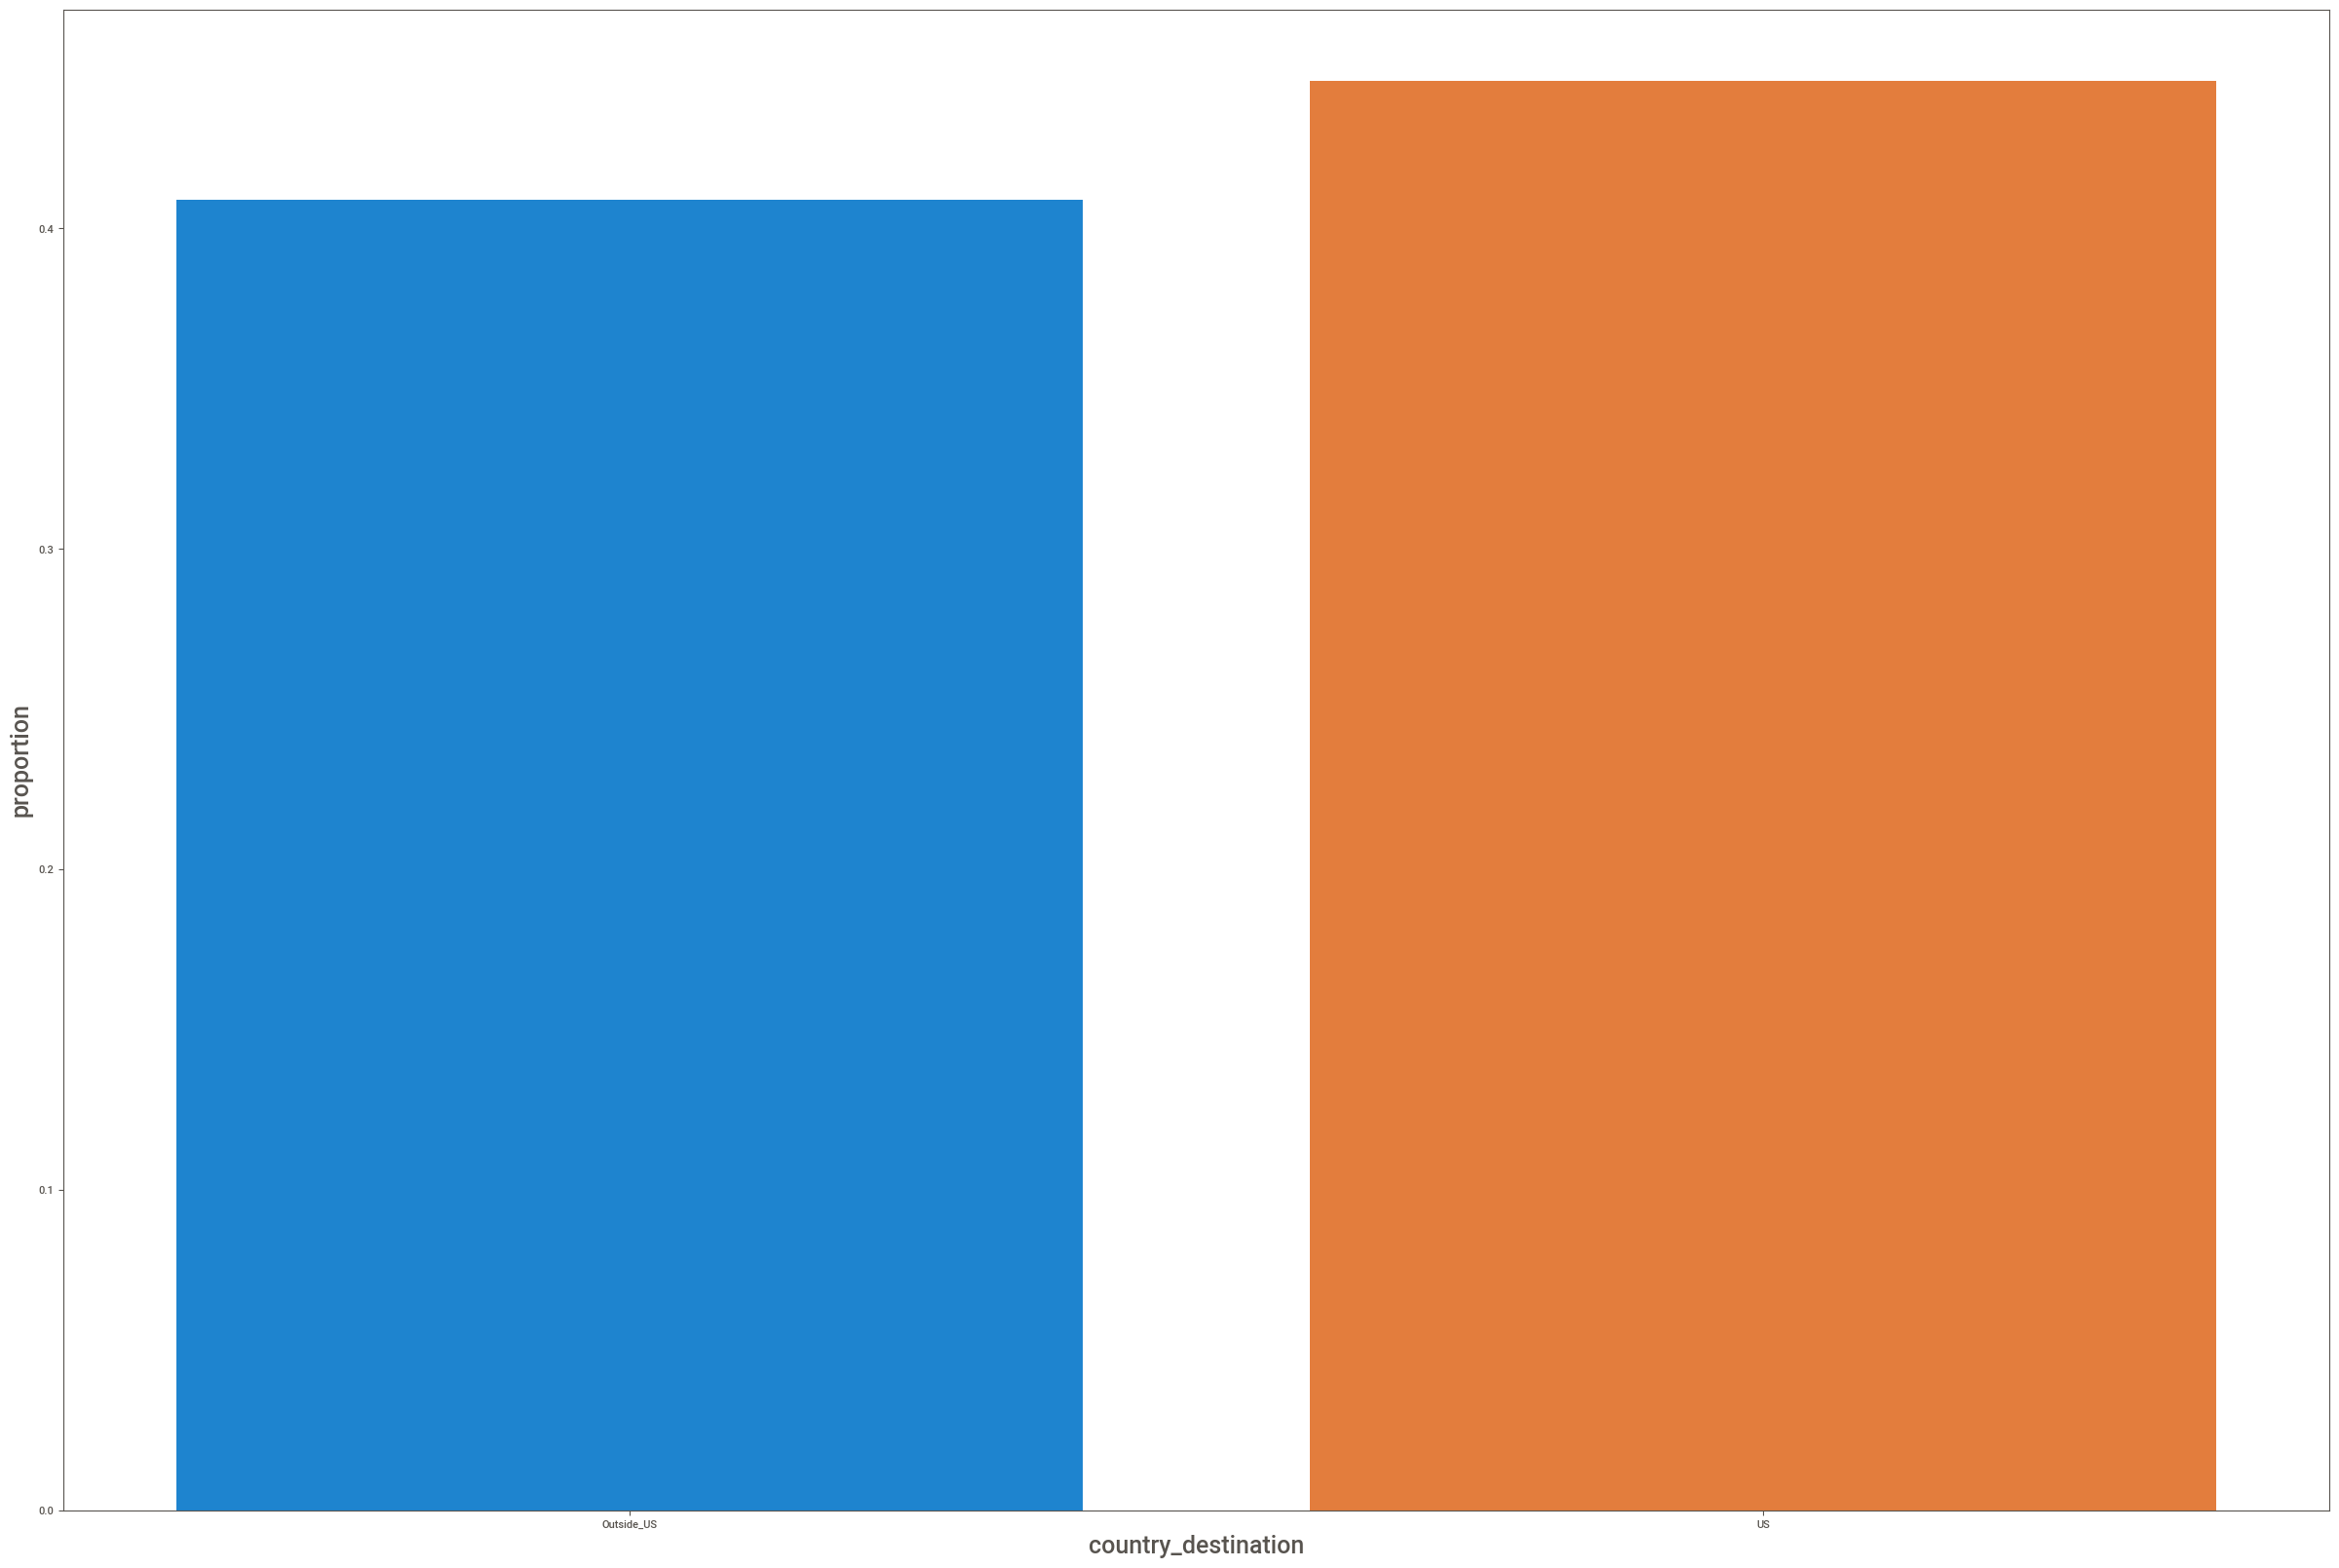

In [34]:
df4_aux1 = pd.DataFrame({'proportion':[df4_outside_US[df4_outside_US['month_first_booking'] > 6]['month_first_booking'].count() / len(df4_outside_US), 
        df4_US[df4_US['month_first_booking'] > 6]['month_first_booking'].count() / len(df4_US) ], 'country_destination': ['Outside_US', 'US'] } )
sns.barplot(x='country_destination', y='proportion', data=df4_aux1);
df4_aux1

False. In fact, the proportion is almost 10% higher inside U.S

In [35]:
tab = [['Hipothesis','Conclusion'],
      ['H1','False'],
      ['H2','False'],
       ['H4','False'],
       ['H5','False'],
       ['H6','False'],
       ['H7','False'],
       ['H9','False'],
       ['H11','False'],
       ['H12','False']]
print(tabulate(tab,headers='firstrow') )


Hipothesis    Conclusion
------------  ------------
H1            False
H2            False
H4            False
H5            False
H6            False
H7            False
H9            False
H11           False
H12           False


# 6.0 Data Preparation and Feature Selection

In [11]:
df5 = df4.copy()

In [12]:
#Excluding variables that are really correlated with others, dates and id,
df5 = df5.drop(['id','date_first_booking','date_account_created','timestamp_first_active','signup_flow','affiliate_provider',
        'year_account_created',
       'year_first_active', 
       'year_first_booking', 
        'weeks_first_active_first_booking',
       'months_first_active_first_booking',
       'days_first_active_account_created',
       'weeks_first_active_account_created',
       'months_first_active_account_created',
       'weeks_account_created_first_booking',
       'months_account_created_first_booking'], axis=1)

predictors = df5.drop('country_destination',axis=1)
response = df5['country_destination']

## 6.1 Split dataframe into training and test dataset

In [13]:
X_train, X_val, y_train,y_val = train_test_split(predictors, response, random_state=42,
                                                               stratify=response)
df5 = pd.concat([X_train, y_train], axis=1)

## 6.2 Transformation and feature selection pipeline

In [18]:
permutation_function = FunctionTransformer(permutation_importance)

In [ ]:
# gender #signup_app signup_method language affiliate_channel first_affiliate_tracked first_device_type first_browser  - frequency encoding

# age -  min max scaler

# month_first_active month_first_booking days_first_active_first_booking  - nature transformation

# days_first_active_first_booking days_account_created_first_booking - Robust Scaler


#country_destination - label encoding
le = LabelEncoder()
y_train = pd.Series(le.fit_transform(y_train), index=y_train.index)
y_val = pd.Series(le.transform(y_val), index=y_val.index)

column_trans = ColumnTransformer(
    [ ('frequency_encod',  CountFrequencyEncoder(encoding_method='frequency'), ['gender','signup_app', 'signup_method', 
      'language', 'affiliate_channel', 'first_affiliate_tracked', 'first_device_type', 'first_browser']  ), 
      ( 'min_max_scaler',MinMaxScaler(), ['age'] ),
      ( 'robust_scaler', RobustScaler(), ['days_first_active_first_booking', 'days_account_created_first_booking'] ),
      ('month_first_active_sin', sin_transformer(12), ['month_first_active'] ),
      ('month_first_active_cos', cos_transformer(12), ['month_first_active'] ),
      ('month_first_booking_sin', sin_transformer(12), ['month_first_booking'] ),
      ('month_first_booking_cos', cos_transformer(12), ['month_first_booking'] ),
      ('month_account_created_sin', sin_transformer(12), ['month_account_created'] ),
      ('month_account_created_cos', cos_transformer(12), ['month_account_created'] ) 
      ], remainder='passthrough', n_jobs=-1 )

classifiers = [RandomForestClassifier(n_jobs=-1, random_state=42), XGBClassifier(n_jobs=-1,  random_state=42),
               lgbm.LGBMClassifier(n_jobs=-1,  random_state=42)]

for classifier in classifiers:
    pipeline_1 = Pipeline(steps= [
        ('preprocessor',column_trans),
        ('feature_selection', SelectFromModel(estimator=classifier) )
        ] )
    pipeline_2 = Pipeline(steps= [
        ('preprocessor',column_trans),
        ('feature_selection', RFE(estimator=classifier) )
        ] )
    print('model: {} \n features selected based on feature importance:{} \n\n'.format(pipeline_1['feature_selection'].estimator,pipeline_1.fit(X_train,y_train).get_feature_names_out(input_features=None) ) )
    del pipeline_1
    print('model: {} \n features_selected based on RFE:{} \n\n'.format(pipeline_2['feature_selection'].estimator,pipeline_2.fit(X_train,y_train).get_feature_names_out(input_features=None) ) )
    del pipeline_2
    # ('rfe_RF', RFE(estimator=RandomForestClassifier(n_jobs=-1) ) ),
    # ('rfe_XGBoost', RFE(estimator=XGBClassifier(n_jobs=-1) ) ),
    # ('rfe_LGBM', RFE(estimator=lgbm.LGBMClassifier(n_jobs=-1) ) ) ] )

    
    


model: RandomForestClassifier(n_jobs=-1, random_state=42) 
 features selected based on feature importance:['min_max_scaler__age' 'robust_scaler__days_first_active_first_booking'
 'robust_scaler__days_account_created_first_booking'] 




In [24]:
 pipeline_1 = Pipeline(steps= [
        ('preprocessor',column_trans),
        ('feature_selection', SelectFromModel(estimator=RandomForestClassifier()) )
        ] )

In [35]:
feature_importance_rf_sorted = pipeline_1['feature_selection'].estimator_.feature_importances_.argsort()
df_feature_importance_rf = pd.DataFrame( {'feature':pipeline_1['feature_selection'].estimator_.feature_names_in_[feature_importance_rf_sorted], 'importance': [feature_importance_rf_sorted] } )


AttributeError: 'RandomForestClassifier' object has no attribute 'feature_names_in_'

In [63]:
pipeline_1['feature_selection'].estimator_.feature_importances_

array([0.03490169, 0.00896932, 0.01942954, 0.00839646, 0.0416334 ,
       0.03848067, 0.03087879, 0.0485401 , 0.16549187, 0.27909425,
       0.25161496, 0.01070103, 0.01093425, 0.01442992, 0.01426852,
       0.01122208, 0.01101315])

In [79]:
pipeline_1['feature_selection'].get_support()

array([False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False])

In [82]:
pipeline_1['feature_selection'].get_feature_names_out()

array(['x8', 'x9', 'x10'], dtype=object)

In [ ]:
pipeline_1.

# Feature Selection

In [62]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']
df4 = df3.drop(cols_drop, axis=1)

In [63]:
predictors = df4.drop('country_destination').copy()
response = df4['country_destination']

NameError: name 'df4' is not defined

In [ ]:
Sequential()